In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import (
    Input, BatchNormalization, ReLU, ELU, Dropout, Conv2D, Dense,
    MaxPool2D, AvgPool2D, GlobalAvgPool2D, Concatenate, SeparableConv2D, UpSampling2D,
)
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical

from PIL import Image, ImageOps  # Pillow library
import random

# Additional imports from the code snippet
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
from keras.preprocessing import image
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from keras import models, layers
from keras.callbacks import TensorBoard
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, SeparableConv2D, UpSampling2D, BatchNormalization, Input, GlobalAveragePooling2D
from keras.regularizers import l2
from keras.optimizers import SGD, RMSprop
from keras.utils import to_categorical

# Set random seed
np.random.seed(1000)
# Ignore information messages from TensorFlow, but we will receive error messages
os.environ['TFF_CPP_MIN_LOG_LEVEL'] = '2'

In [6]:
PARENT_DATA_DIR = '/content/drive/MyDrive/OD(75-15-10)'
TRAIN_DATA_DIR = os.path.join(PARENT_DATA_DIR, 'train')
VALID_DATA_DIR = os.path.join(PARENT_DATA_DIR, 'valid')
TEST_DATA_DIR = os.path.join(PARENT_DATA_DIR, 'test')

In [7]:

IMG_SIZE = 128
dataset_classes = []
for i in os.listdir(TRAIN_DATA_DIR):
    dataset_classes.append(i)

number_of_classes = len(dataset_classes)
print(f"""

    Classes: {dataset_classes}
    Number of classes: {number_of_classes}""")



    Classes: ['Pathological_Myopia', 'Other_diseases_abnormalities', 'Normal', 'Hypertension', 'Glaucoma', 'Diabetes', 'Cataract', 'Age_related_Macular_Degeneration']
    Number of classes: 8


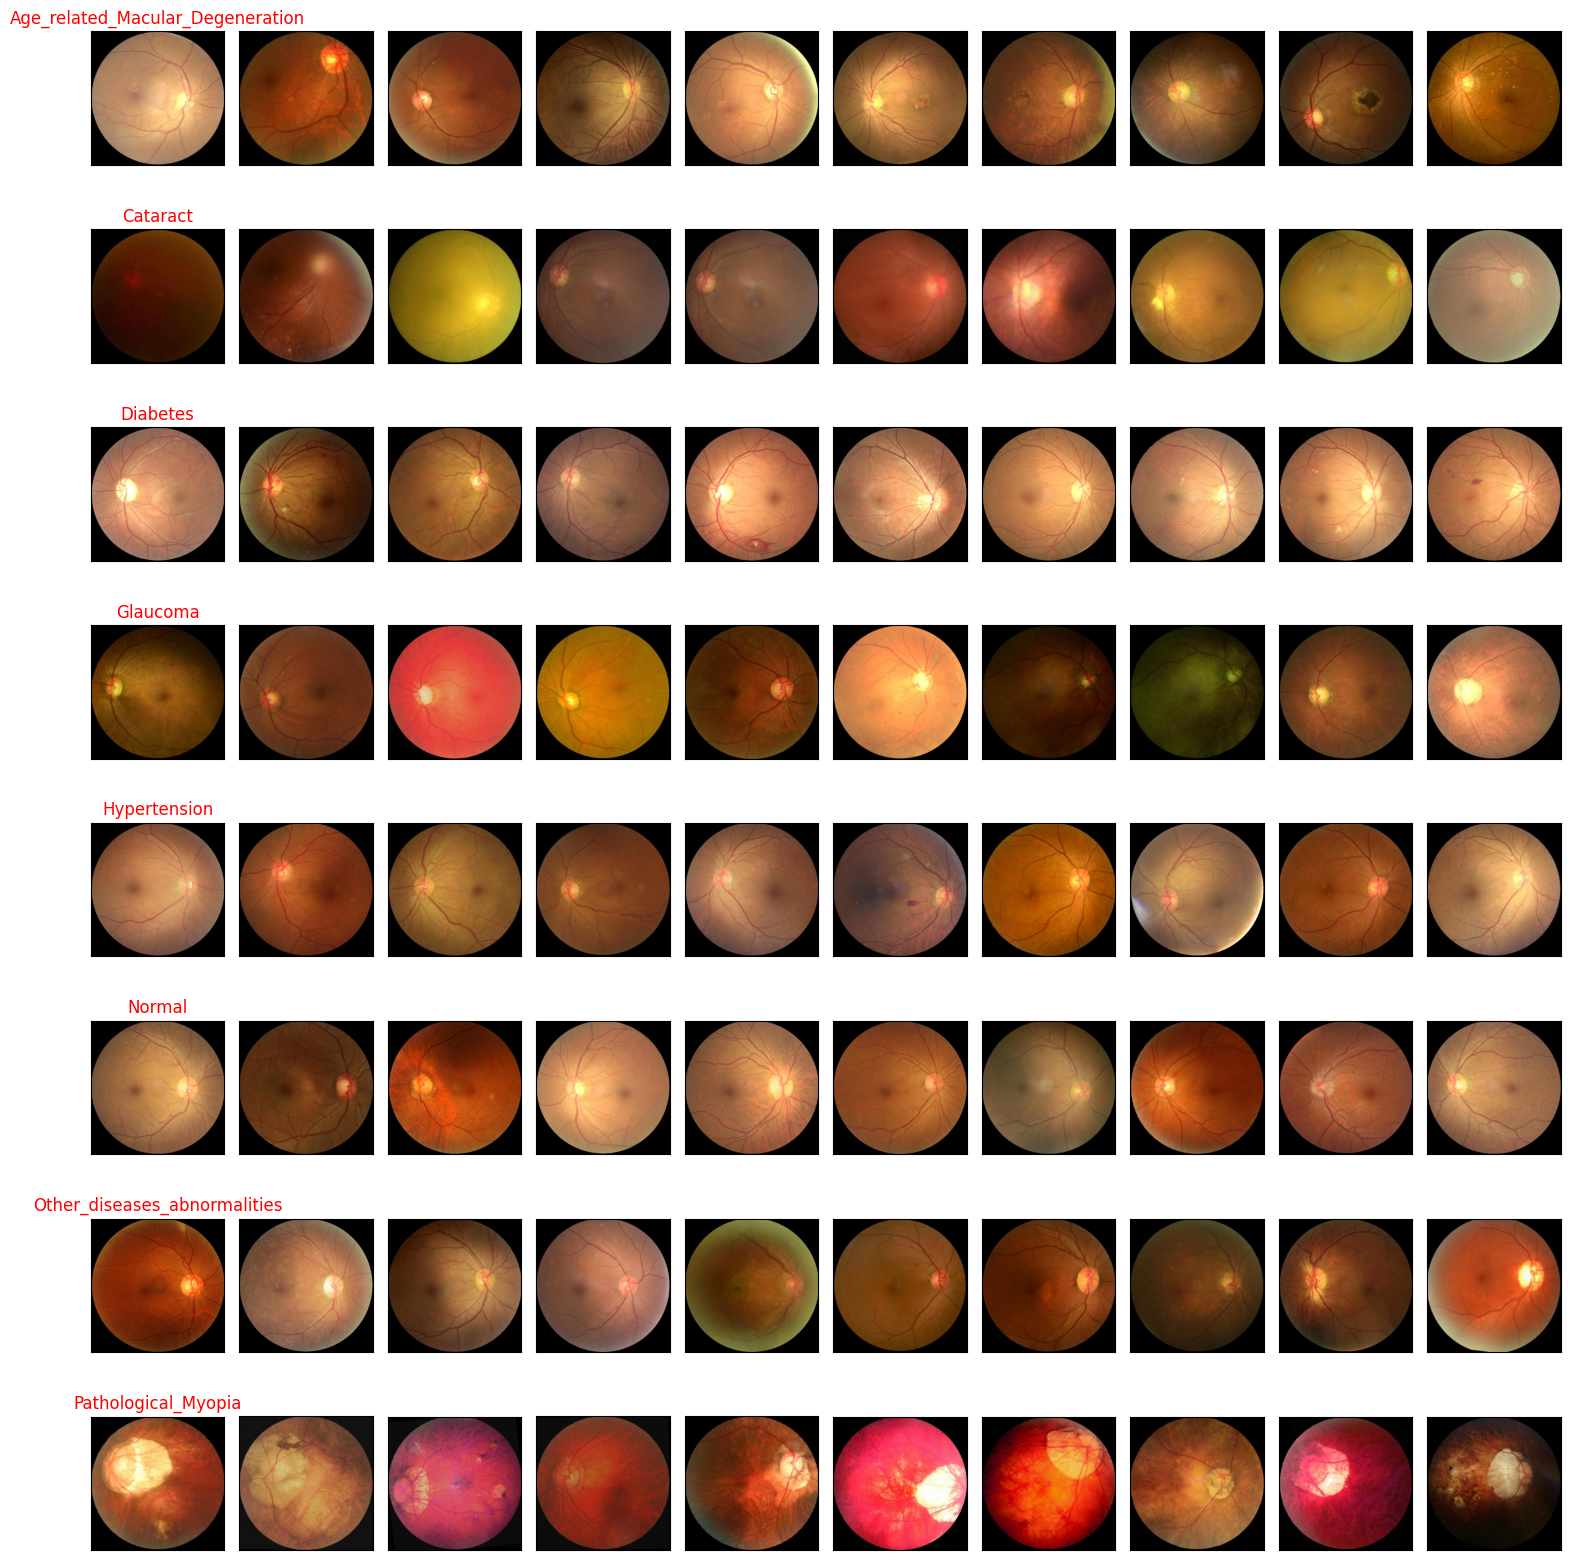

In [ ]:
plt.figure(figsize=(15, 20), facecolor='white')
i = 1
for c in dataset_classes:
    path = os.path.join(TRAIN_DATA_DIR, c)
    image_list = os.listdir(path)
    random.shuffle(image_list)
    image_list = image_list[:10]
    for img_name in image_list:
        img_array = cv2.imread(os.path.join(path, img_name))
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        white_background = 255 * np.ones_like(img_array)
        x_offset = (white_background.shape[1] - img_array.shape[1]) // 2
        y_offset = (white_background.shape[0] - img_array.shape[0]) // 2
        white_background[y_offset:y_offset + img_array.shape[0], x_offset:x_offset + img_array.shape[1], :] = img_array
        plt.subplot(10, 10, i)
        plt.imshow(white_background)
        if i % 10 == 1:
            plt.title(c, color='red')
        plt.xticks([])
        plt.yticks([])
        i += 1

plt.tight_layout()
plt.show()

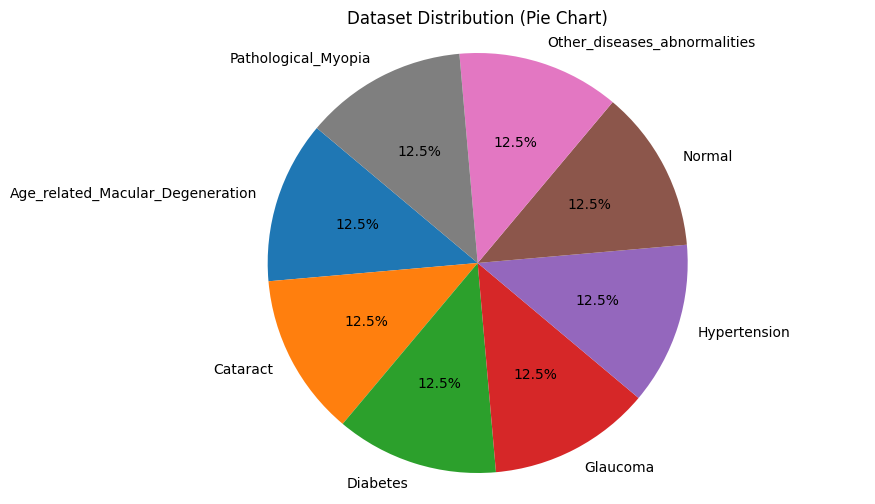

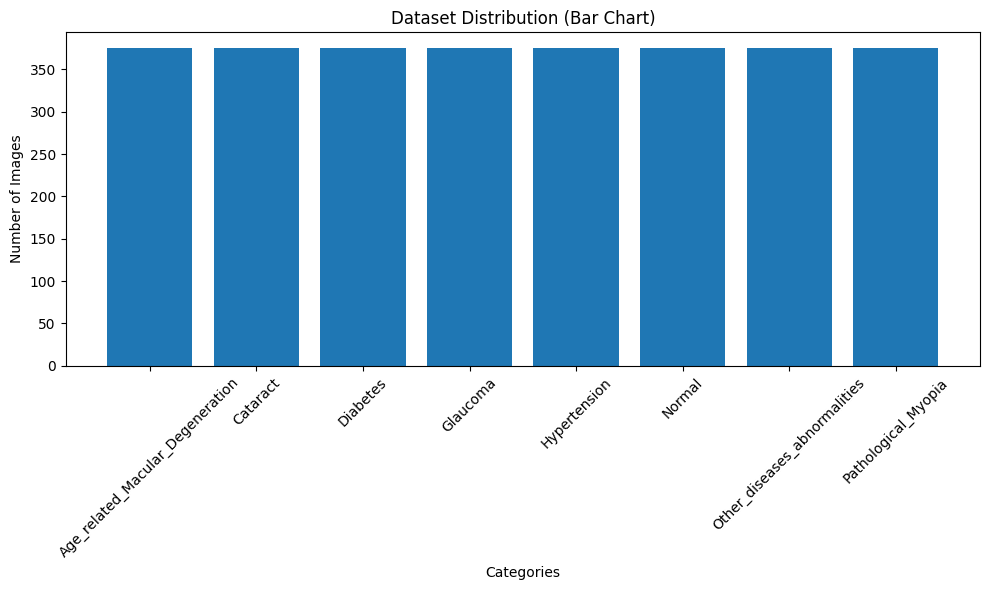

In [ ]:
category_counts = {}
for category in dataset_classes:
    category_path = os.path.join(TRAIN_DATA_DIR, category)
    num_images = len(os.listdir(category_path))
    category_counts[category] = num_images


plt.figure(figsize=(10, 6), facecolor='white')
plt.pie(category_counts.values(), labels=category_counts.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Dataset Distribution (Pie Chart)')
plt.axis('equal')
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(category_counts.keys(), category_counts.values())
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Dataset Distribution (Bar Chart)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
training_data = []

for c in dataset_classes:
    path = os.path.join(TRAIN_DATA_DIR, c)
    class_num = dataset_classes.index(c)
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            training_data.append([img_resized, class_num])
        except Exception as e:
            pass

print(len(training_data))

100%|██████████| 375/375 [00:04<00:00, 84.47it/s] 

3000


In [9]:
validation_data = []

for c in dataset_classes:
    path = os.path.join(VALID_DATA_DIR, c)
    class_num = dataset_classes.index(c)
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            validation_data.append([img_resized, class_num])
        except Exception as e:
            pass

print(len(validation_data))

100%|██████████| 75/75 [00:14<00:00,  5.19it/s]

600


In [10]:
test_data = []

for c in dataset_classes:
    path = os.path.join(TEST_DATA_DIR, c)
    class_num = dataset_classes.index(c)
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            test_data.append([img_resized, class_num])
        except Exception as e:
            pass

print(len(test_data))

100%|██████████| 50/50 [00:09<00:00,  5.23it/s]

400


In [11]:
X_train = []
Y_train = []

for img, label in training_data:
    X_train.append(img)
    Y_train.append(label)

X_train = np.array(X_train).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_train = np.array(Y_train)

print(f"X_train= {X_train.shape} Y_train= {Y_train.shape}")

X_train= (3000, 128, 128, 3) Y_train= (3000,)


In [12]:
X_valid = []
Y_valid = []

for features,label in validation_data:
    X_valid.append(features)
    Y_valid.append(label)

X_valid = np.array(X_valid).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_valid = np.array(Y_valid)

print(f"X_valid= {X_valid.shape} Y_valid= {Y_valid.shape}")

X_valid= (600, 128, 128, 3) Y_valid= (600,)


In [13]:
X_test = []
Y_test = []

for features,label in test_data:
    X_test.append(features)
    Y_test.append(label)

X_test = np.array(X_test).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_test = np.array(Y_test)

print(f"X_test= {X_test.shape} Y_test= {Y_test.shape}")

X_train, X_valid, X_test = X_train / 255.0, X_valid / 255.0, X_test / 255.0

X_test= (400, 128, 128, 3) Y_test= (400,)


CNN

In [ ]:
bcnn_model = Sequential()
bcnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
bcnn_model.add(MaxPooling2D((2, 2)))
bcnn_model.add(Conv2D(64, (3, 3), activation='relu'))
bcnn_model.add(MaxPooling2D((2, 2)))
bcnn_model.add(Conv2D(128, (3, 3), activation='relu'))
bcnn_model.add(MaxPooling2D((2, 2)))
bcnn_model.add(Flatten())
bcnn_model.add(Dense(512, activation='relu'))
bcnn_model.add(Dropout(0.5))
bcnn_model.add(BatchNormalization())
bcnn_model.add(Dense(number_of_classes, activation='softmax'))

In [ ]:
bcnn_model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
bcnn = bcnn_model.fit(X_train, Y_train, epochs=100, validation_data=(X_valid, Y_valid), batch_size=64)

Epoch 1/100
47/47 [==============================] - 16s 60ms/step - loss: 2.0073 - accuracy: 0.2363 - val_loss: 1.8185 - val_accuracy: 0.3433
Epoch 2/100
47/47 [==============================] - 2s 40ms/step - loss: 1.6036 - accuracy: 0.3903 - val_loss: 1.7738 - val_accuracy: 0.3567
Epoch 3/100
47/47 [==============================] - 2s 46ms/step - loss: 1.3729 - accuracy: 0.4717 - val_loss: 1.5153 - val_accuracy: 0.5050
Epoch 4/100
47/47 [==============================] - 2s 44ms/step - loss: 1.2546 - accuracy: 0.5143 - val_loss: 1.4500 - val_accuracy: 0.4517
Epoch 5/100
47/47 [==============================] - 2s 42ms/step - loss: 1.1774 - accuracy: 0.5447 - val_loss: 1.2572 - val_accuracy: 0.5667
Epoch 6/100
47/47 [==============================] - 2s 39ms/step - loss: 1.0896 - accuracy: 0.5917 - val_loss: 1.3045 - val_accuracy: 0.4967
Epoch 7/100
47/47 [==============================] - 2s 39ms/step - loss: 1.0102 - accuracy: 0.6150 - val_loss: 1.0734 - val_accuracy: 0.6850
Epoch

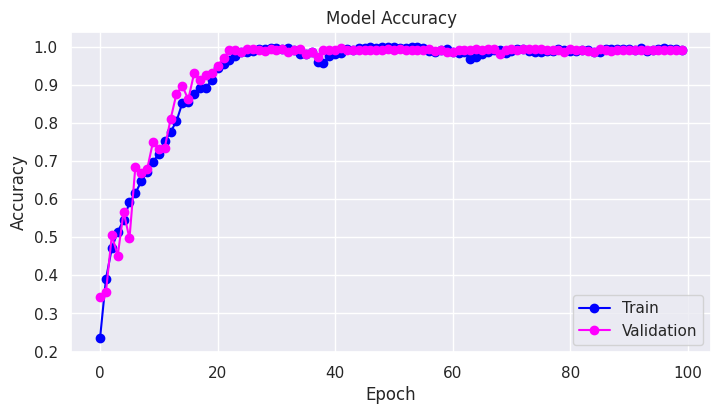

In [ ]:
import seaborn as sns
#  "Accuracy"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(bcnn.history['accuracy'], 'o-',color="blue")
plt.plot(bcnn.history['val_accuracy'] ,'o-', color="magenta")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
#plt.close()

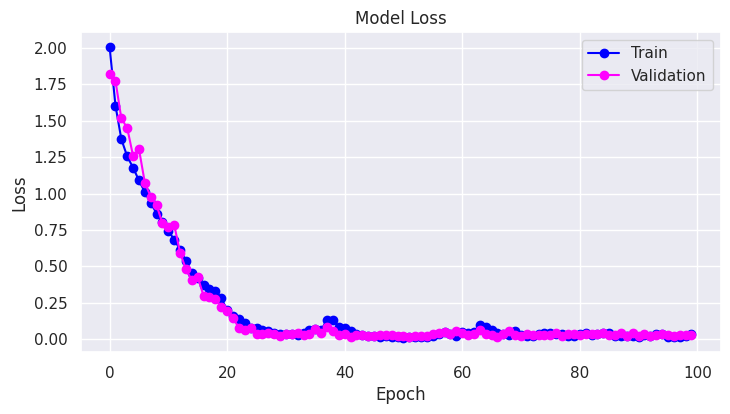

In [ ]:
# "Loss"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(bcnn.history['loss'],'o-', color="blue")
plt.plot(bcnn.history['val_loss'],'o-', color="magenta")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])

In [ ]:
valid_loss, valid_acc = bcnn_model.evaluate(X_valid, Y_valid)
train_loss, train_acc=bcnn_model.evaluate(X_train, Y_train)
print('\nValidation Accuracy:', valid_acc)
print('\nValidation Loss:', valid_loss)
print('\nTrain Accuracy:', train_acc)
print('\nTrain Loss:', train_loss)

94/94 [==============================] - 1s 8ms/step - loss: 0.0044 - accuracy: 0.9990

Validation Accuracy: 0.9900000095367432

Validation Loss: 0.02540033869445324

Train Accuracy: 0.9990000128746033

Train Loss: 0.004416943993419409


In [ ]:
score = bcnn_model.evaluate(X_valid,Y_valid,verbose=0)
print("Accuracy: ",np.round(score[1]*100,3),"%")

Accuracy:  99.0 %


In [ ]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

testX_arg = np.argmax(Y_valid)
y_pred = np.argmax(bcnn_model.predict(X_valid), axis=1)
y_true = np.argmax(Y_valid)
# print(y_pred)
# print(y_pred.shape)
cm = confusion_matrix(Y_valid,y_pred)
print(classification_report(Y_valid, y_pred,  digits=3,target_names = dataset_classes))

19/19 [==============================] - 0s 6ms/step
                                  precision    recall  f1-score   support

    Other_diseases_abnormalities      1.000     0.987     0.993        75
             Pathological_Myopia      1.000     1.000     1.000        75
                    Hypertension      0.987     1.000     0.993        75
                          Normal      0.973     0.973     0.973        75
                        Cataract      1.000     1.000     1.000        75
                        Diabetes      0.973     0.960     0.966        75
                        Glaucoma      1.000     1.000     1.000        75
Age_related_Macular_Degeneration      0.987     1.000     0.993        75

                        accuracy                          0.990       600
                       macro avg      0.990     0.990     0.990       600
                    weighted avg      0.990     0.990     0.990       600



### Evaluate Validation Dataset

<Axes: title={'center': 'Confusion Matrix'}>

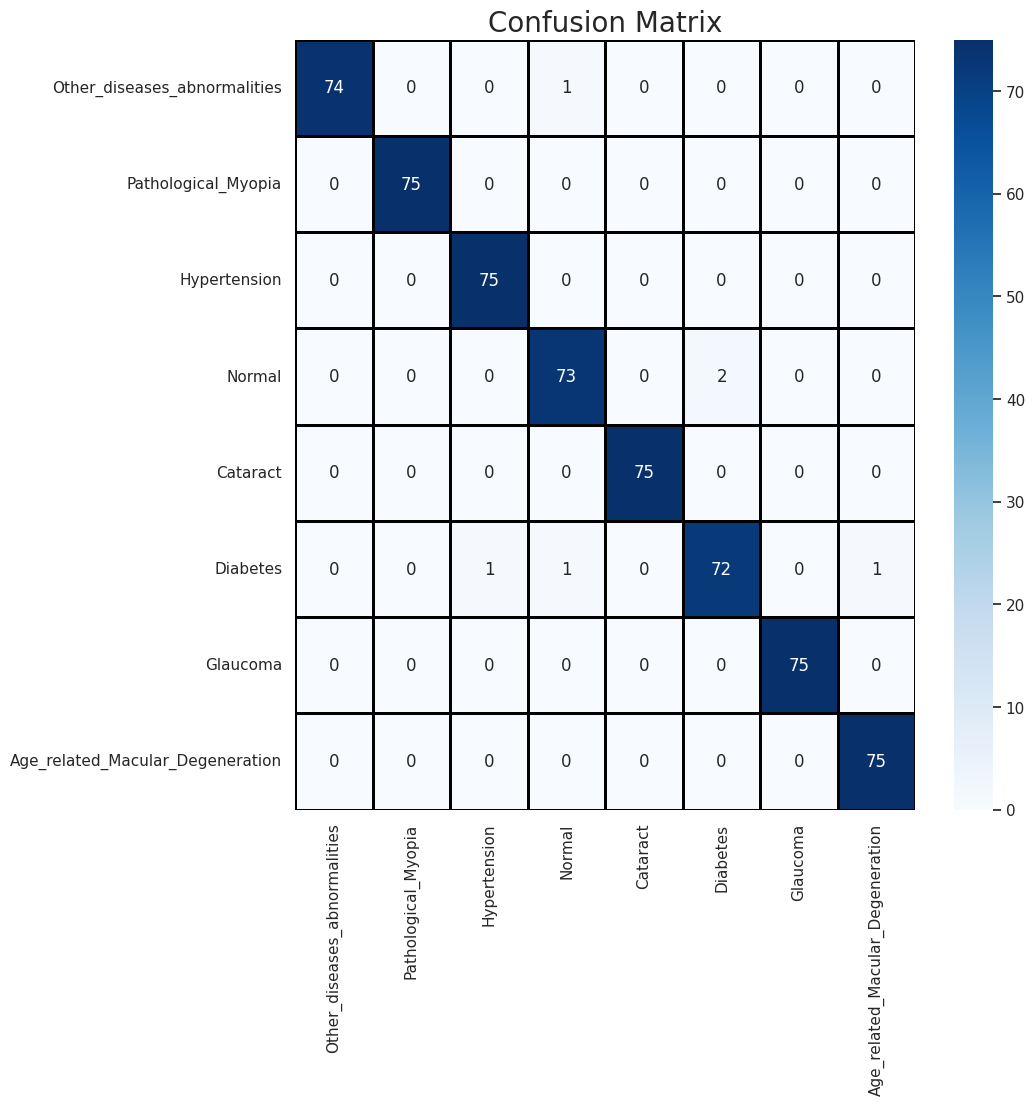

In [ ]:
import pandas as pd
cm = pd.DataFrame(cm , index = dataset_classes , columns = dataset_classes)
plt.figure(figsize = (10,10))
plt.title("Confusion Matrix", fontsize =20)
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = dataset_classes,yticklabels = dataset_classes)

19/19 [==============================] - 0s 7ms/step


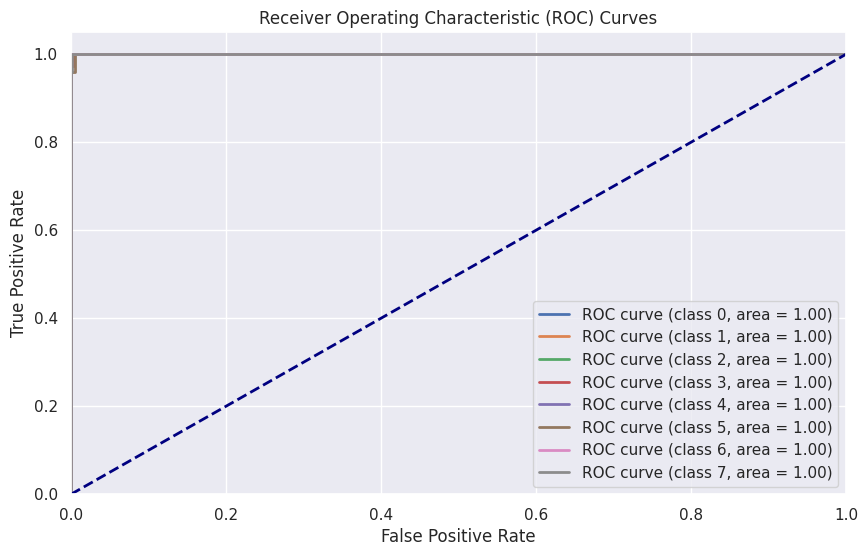

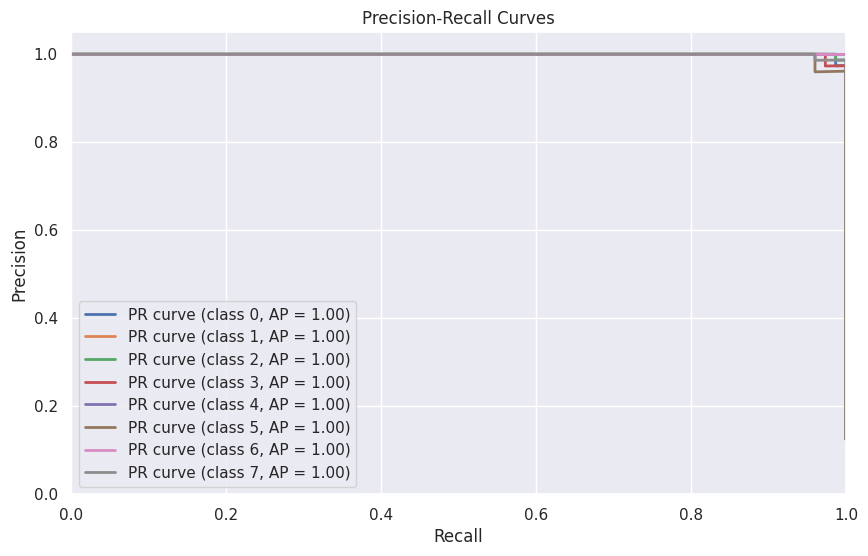

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
model_output = bcnn_model.predict(X_valid)
n_classes = len(dataset_classes)
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_valid == i, model_output[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    precision[i], recall[i], _ = precision_recall_curve(Y_valid == i, model_output[:, i])
    average_precision[i] = auc(recall[i], precision[i])

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (class {i}, area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="best")
plt.show()

# Plot PR curves
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'PR curve (class {i}, AP = {average_precision[i]:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="best")
plt.show()

## Evaluate Test Dataset

In [ ]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

testX_arg = np.argmax(Y_test)
y_pred = np.argmax(bcnn_model.predict(X_test), axis=1)
y_true = np.argmax(Y_test)
# print(y_pred)
# print(y_pred.shape)
cm = confusion_matrix(Y_test,y_pred)
print(classification_report(Y_test, y_pred,  digits=3,target_names = dataset_classes))

13/13 [==============================] - 0s 16ms/step
                                  precision    recall  f1-score   support

    Other_diseases_abnormalities      0.829     0.680     0.747        50
             Pathological_Myopia      1.000     1.000     1.000        50
                    Hypertension      0.913     0.840     0.875        50
                          Normal      0.805     0.660     0.725        50
                        Cataract      0.909     1.000     0.952        50
                        Diabetes      0.636     0.840     0.724        50
                        Glaucoma      0.860     0.980     0.916        50
Age_related_Macular_Degeneration      0.886     0.780     0.830        50

                        accuracy                          0.848       400
                       macro avg      0.855     0.847     0.846       400
                    weighted avg      0.855     0.848     0.846       400



<Axes: title={'center': 'Confusion Matrix'}>

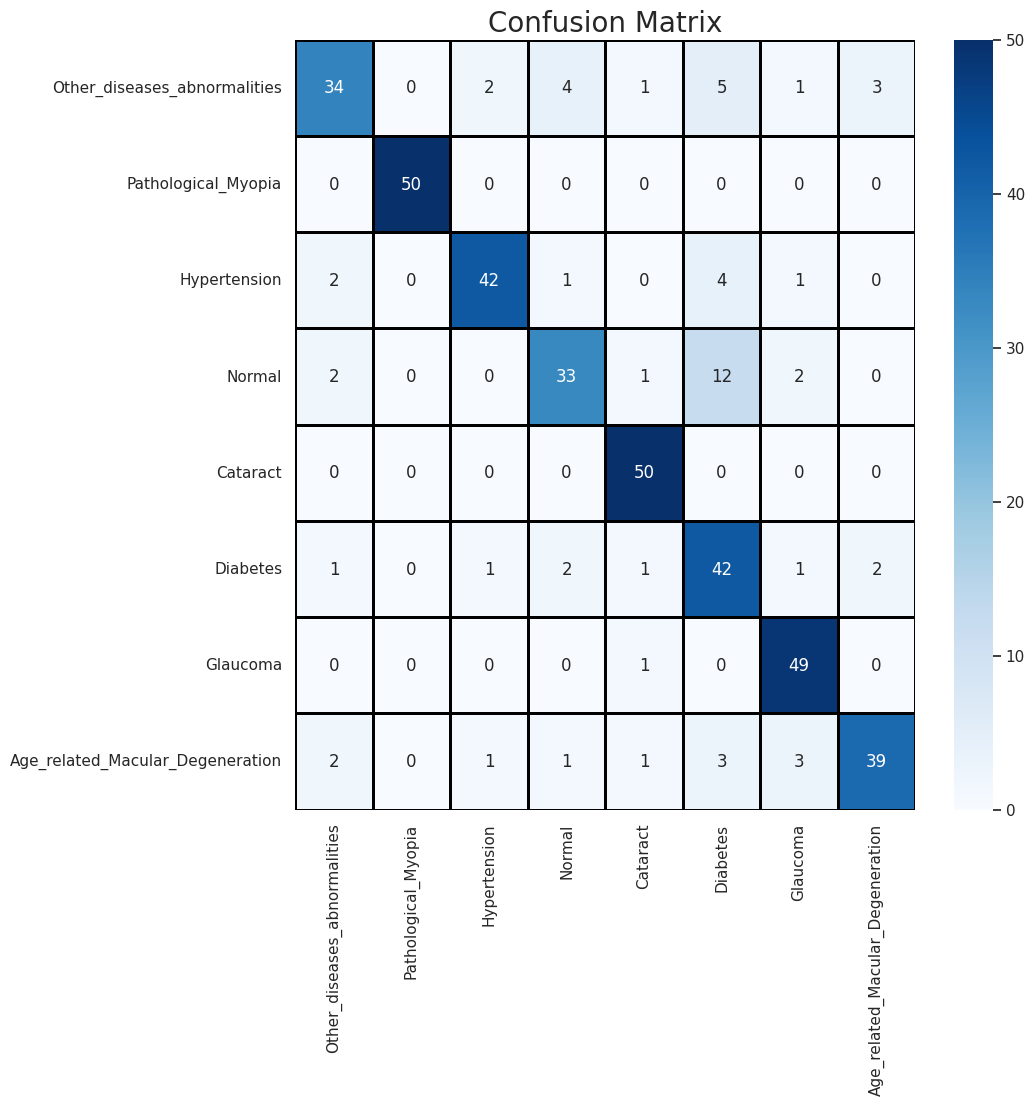

In [ ]:
import pandas as pd
cm = pd.DataFrame(cm , index = dataset_classes , columns = dataset_classes)
plt.figure(figsize = (10,10))
plt.title("Confusion Matrix", fontsize =20)
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = dataset_classes,yticklabels = dataset_classes)

### Densenet121

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Load the DenseNet121 model with pre-trained weights (include_top=False for feature extraction)
DenseNet121_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze all layers of the pre-trained model
for layer in DenseNet121_model.layers:
    layer.trainable = False

# Create a new Sequential model
DenseNet121_custom_model = Sequential()
DenseNet121_custom_model.add(DenseNet121_model)
DenseNet121_custom_model.add(Flatten())
DenseNet121_custom_model.add(Dense(128, activation='relu'))
DenseNet121_custom_model.add(Dense(number_of_classes, activation='softmax'))
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
DenseNet121_custom_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
DenseNet121_pretrained = DenseNet121_custom_model.fit(X_train, Y_train, epochs=100, validation_data=(X_valid, Y_valid), batch_size=64)

Epoch 1/100
47/47 [==============================] - 19s 211ms/step - loss: 3.4380 - accuracy: 0.3633 - val_loss: 1.2934 - val_accuracy: 0.5183
Epoch 2/100
47/47 [==============================] - 4s 81ms/step - loss: 1.1665 - accuracy: 0.5540 - val_loss: 1.1155 - val_accuracy: 0.5767
Epoch 3/100
47/47 [==============================] - 4s 80ms/step - loss: 0.9839 - accuracy: 0.6360 - val_loss: 0.8785 - val_accuracy: 0.6733
Epoch 4/100
47/47 [==============================] - 4s 79ms/step - loss: 0.8736 - accuracy: 0.6797 - val_loss: 0.7971 - val_accuracy: 0.7183
Epoch 5/100
47/47 [==============================] - 4s 86ms/step - loss: 0.7802 - accuracy: 0.7060 - val_loss: 0.7378 - val_accuracy: 0.7350
Epoch 6/100
47/47 [==============================] - 4s 82ms/step - loss: 0.7017 - accuracy: 0.7480 - val_loss: 0.6731 - val_accuracy: 0.7667
Epoch 7/100
47/47 [==============================] - 4s 80ms/step - loss: 0.6806 - accuracy: 0.7550 - val_loss: 0.6505 - val_accuracy: 0.7717
Epoc

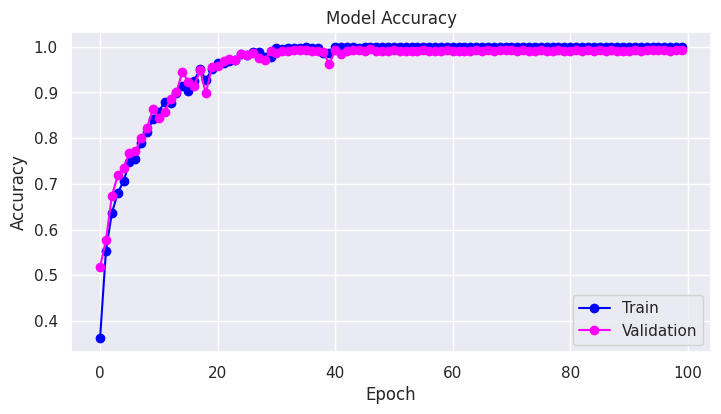

In [ ]:
#  "Accuracy"
import seaborn as sns
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(DenseNet121_pretrained.history['accuracy'], 'o-',color="blue")
plt.plot(DenseNet121_pretrained.history['val_accuracy'] ,'o-', color="magenta")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
#plt.close()

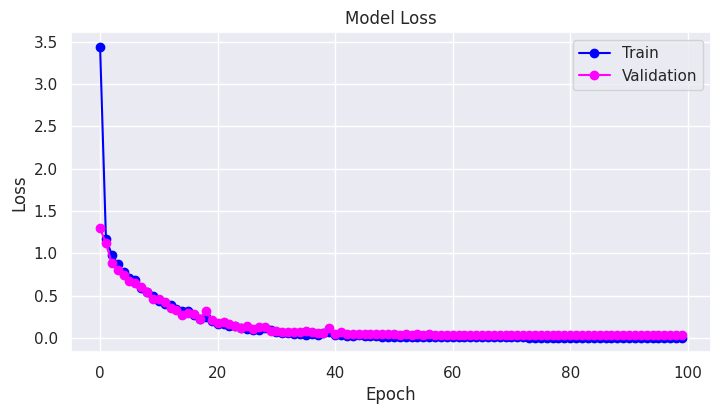

In [ ]:
# "Loss"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(DenseNet121_pretrained.history['loss'],'o-', color="blue")
plt.plot(DenseNet121_pretrained.history['val_loss'],'o-', color="magenta")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])

In [ ]:
valid_loss, valid_acc = DenseNet121_custom_model.evaluate(X_valid, Y_valid)
train_loss, train_acc=DenseNet121_custom_model.evaluate(X_train, Y_train)
print('\nValidation Accuracy:', valid_acc)
print('\nValidation Loss:', valid_loss)
print('\nTrain Accuracy:', train_acc)
print('\nTrain Loss:', train_loss)

94/94 [==============================] - 4s 38ms/step - loss: 0.0014 - accuracy: 1.0000

Validation Accuracy: 0.9933333396911621

Validation Loss: 0.0374622717499733

Train Accuracy: 1.0

Train Loss: 0.001370181911624968


In [ ]:
score = DenseNet121_custom_model.evaluate(X_valid,Y_valid,verbose=0)
print("Accuracy: ",np.round(score[1]*100,3),"%")

Accuracy:  99.333 %


In [ ]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

testX_arg = np.argmax(Y_valid)
y_pred = np.argmax(DenseNet121_custom_model.predict(X_valid), axis=1)
y_true = np.argmax(Y_valid)
# print(y_pred)
# print(y_pred.shape)
cm = confusion_matrix(Y_valid,y_pred)
print(classification_report(Y_valid, y_pred,  digits=3,target_names = dataset_classes))

19/19 [==============================] - 2s 36ms/step
                                  precision    recall  f1-score   support

    Other_diseases_abnormalities      1.000     0.973     0.986        75
             Pathological_Myopia      1.000     1.000     1.000        75
                    Hypertension      1.000     1.000     1.000        75
                          Normal      1.000     0.987     0.993        75
                        Cataract      1.000     1.000     1.000        75
                        Diabetes      0.987     0.987     0.987        75
                        Glaucoma      0.974     1.000     0.987        75
Age_related_Macular_Degeneration      0.987     1.000     0.993        75

                        accuracy                          0.993       600
                       macro avg      0.993     0.993     0.993       600
                    weighted avg      0.993     0.993     0.993       600



### Evaluate Validation Dataset

<Axes: title={'center': 'Confusion Matrix'}>

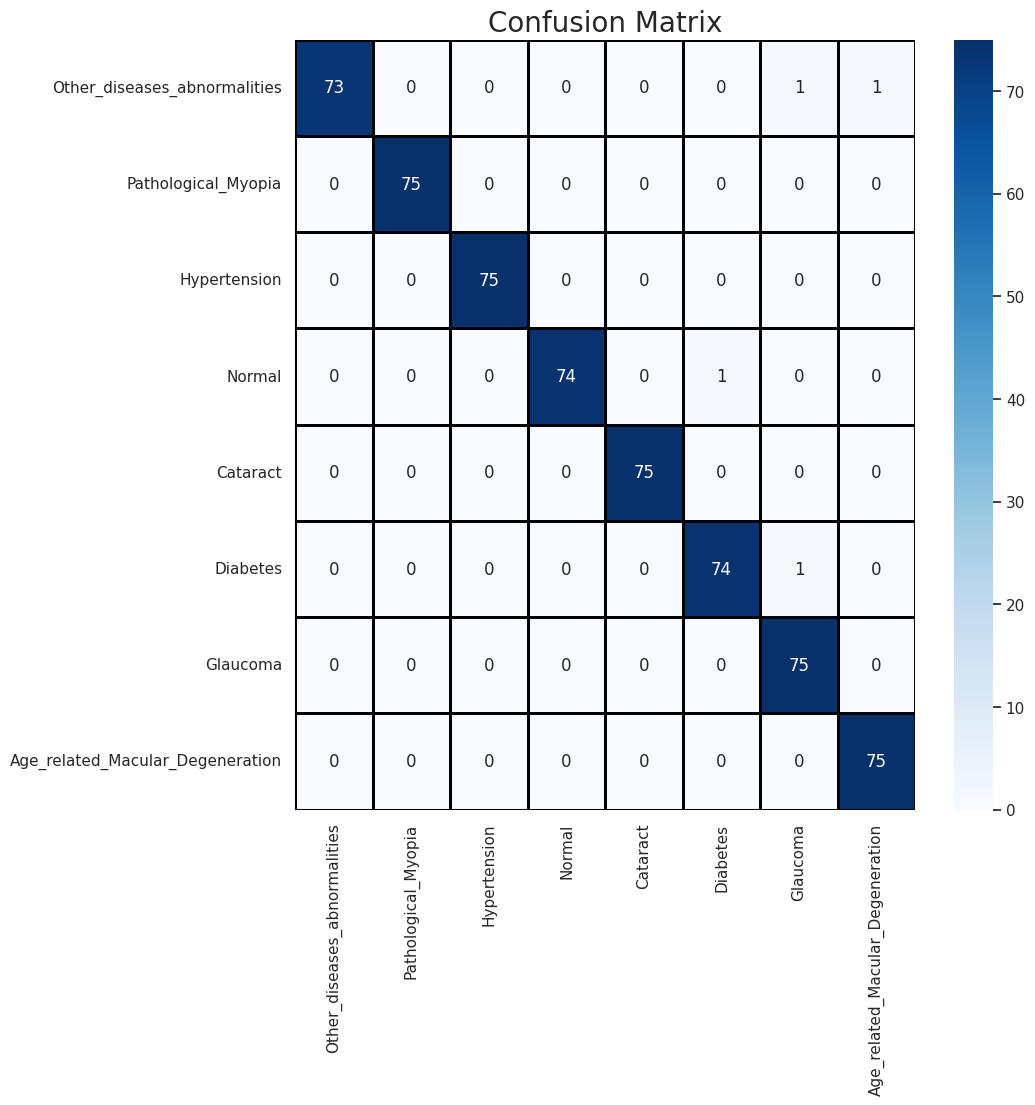

In [ ]:
import pandas as pd
cm = pd.DataFrame(cm , index = dataset_classes , columns = dataset_classes)
plt.figure(figsize = (10,10))
plt.title("Confusion Matrix", fontsize =20)
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = dataset_classes,yticklabels = dataset_classes)

19/19 [==============================] - 1s 32ms/step


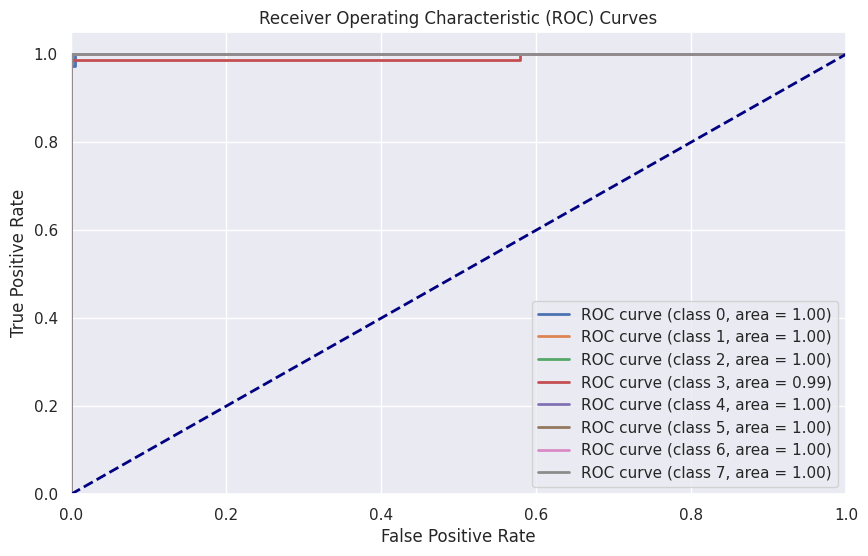

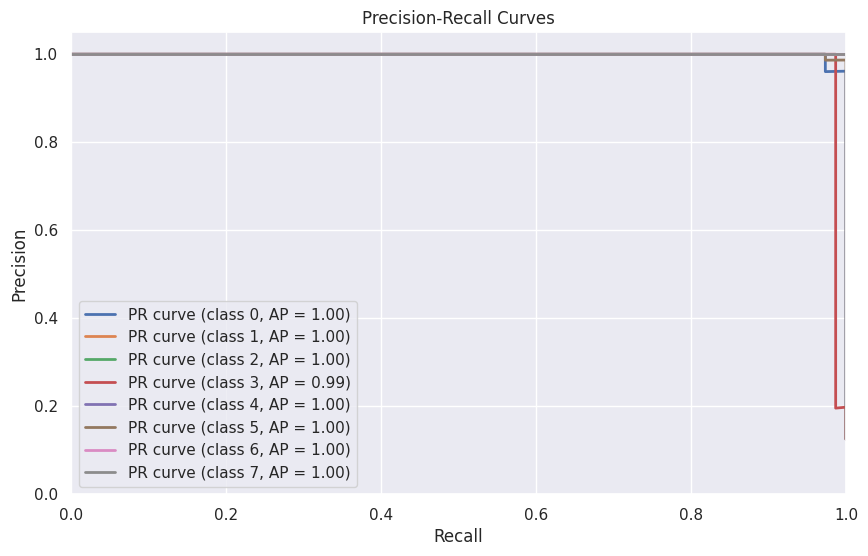

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
model_output = DenseNet121_custom_model.predict(X_valid)
n_classes = len(dataset_classes)
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_valid == i, model_output[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    precision[i], recall[i], _ = precision_recall_curve(Y_valid == i, model_output[:, i])
    average_precision[i] = auc(recall[i], precision[i])

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (class {i}, area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="best")
plt.show()

# Plot PR curves
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'PR curve (class {i}, AP = {average_precision[i]:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="best")
plt.show()

## Evaluate Test Dataset

In [ ]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

testX_arg = np.argmax(Y_test)
y_pred = np.argmax(DenseNet121_custom_model.predict(X_test), axis=1)
y_true = np.argmax(Y_test)
# print(y_pred)
# print(y_pred.shape)
cm = confusion_matrix(Y_test,y_pred)
print(classification_report(Y_test, y_pred,  digits=3,target_names = dataset_classes))

13/13 [==============================] - 2s 125ms/step
                                  precision    recall  f1-score   support

    Other_diseases_abnormalities      0.854     0.820     0.837        50
             Pathological_Myopia      1.000     1.000     1.000        50
                    Hypertension      0.980     0.960     0.970        50
                          Normal      0.875     0.840     0.857        50
                        Cataract      1.000     1.000     1.000        50
                        Diabetes      0.849     0.900     0.874        50
                        Glaucoma      0.943     1.000     0.971        50
Age_related_Macular_Degeneration      0.959     0.940     0.949        50

                        accuracy                          0.932       400
                       macro avg      0.933     0.932     0.932       400
                    weighted avg      0.933     0.932     0.932       400



<Axes: title={'center': 'Confusion Matrix'}>

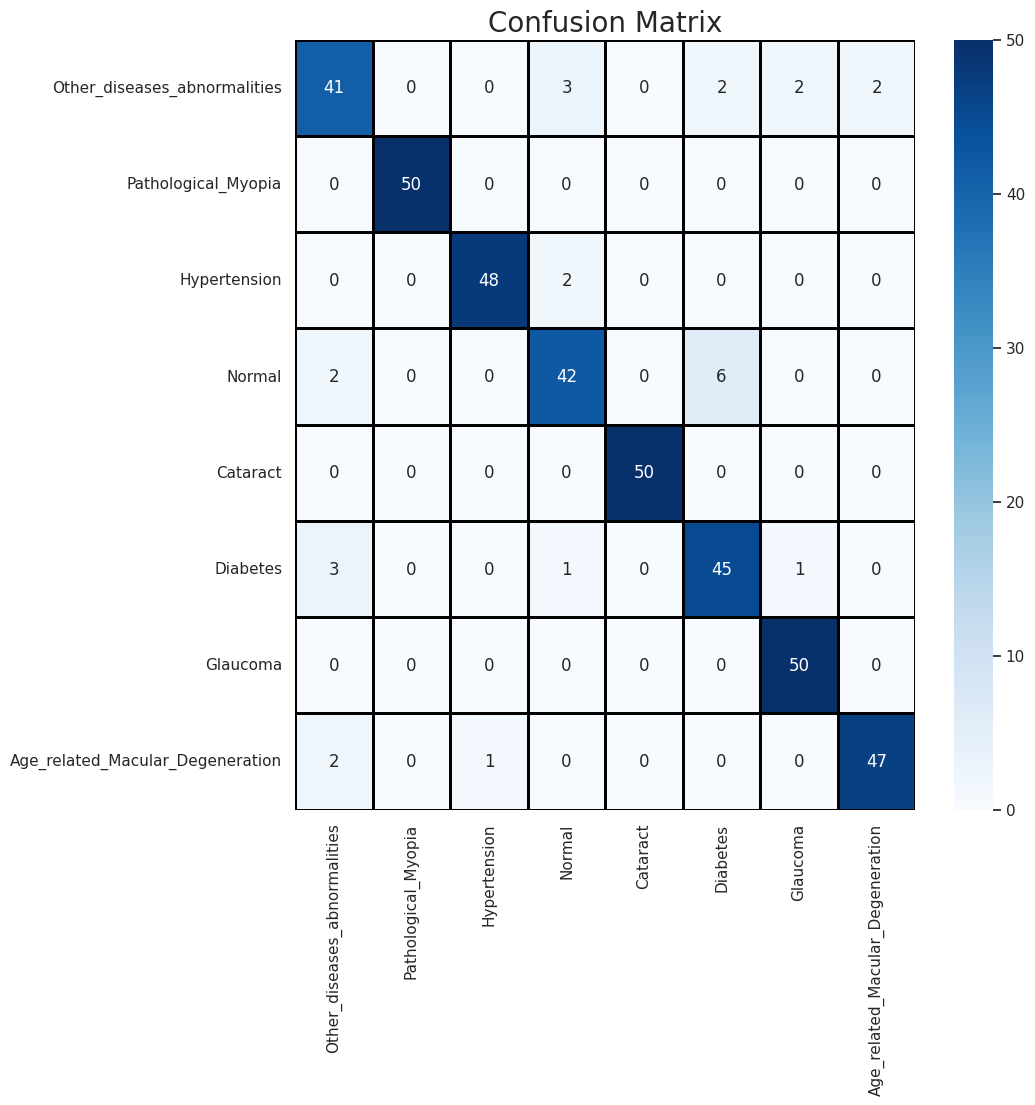

In [ ]:
import pandas as pd
cm = pd.DataFrame(cm , index = dataset_classes , columns = dataset_classes)
plt.figure(figsize = (10,10))
plt.title("Confusion Matrix", fontsize =20)
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = dataset_classes,yticklabels = dataset_classes)

### Efficientnet B4

In [ ]:
!pip install -q efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 862.9 kB/s eta 0:00:00


In [ ]:
import efficientnet.tfkeras as efn

enet = efn.EfficientNetB4(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet',
    include_top=False
)
x = enet.output
x = tf.keras.layers.GlobalMaxPooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
y = tf.keras.layers.Dense(number_of_classes, activation='softmax')(x)

e_model_b4 = tf.keras.Model(inputs=enet.input, outputs=y)
e_model_b4.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

71892840/71892840 [==============================] - 0s 0us/step


In [ ]:
efficientnet_b4 = e_model_b4.fit(x=X_train, y=Y_train, epochs=100, validation_data=(X_valid, Y_valid), batch_size=64)

Epoch 1/100
47/47 [==============================] - 118s 540ms/step - loss: 2.0518 - accuracy: 0.3687 - val_loss: 2.0022 - val_accuracy: 0.3067
Epoch 2/100
47/47 [==============================] - 21s 446ms/step - loss: 1.1724 - accuracy: 0.5673 - val_loss: 1.6759 - val_accuracy: 0.3700
Epoch 3/100
47/47 [==============================] - 20s 424ms/step - loss: 0.8228 - accuracy: 0.7000 - val_loss: 1.4781 - val_accuracy: 0.4783
Epoch 4/100
47/47 [==============================] - 20s 432ms/step - loss: 0.6002 - accuracy: 0.7767 - val_loss: 1.1194 - val_accuracy: 0.5983
Epoch 5/100
47/47 [==============================] - 20s 435ms/step - loss: 0.4582 - accuracy: 0.8273 - val_loss: 0.7836 - val_accuracy: 0.7233
Epoch 6/100
47/47 [==============================] - 20s 434ms/step - loss: 0.3192 - accuracy: 0.8837 - val_loss: 0.4784 - val_accuracy: 0.8250
Epoch 7/100
47/47 [==============================] - 20s 430ms/step - loss: 0.2400 - accuracy: 0.9157 - val_loss: 0.3730 - val_accuracy

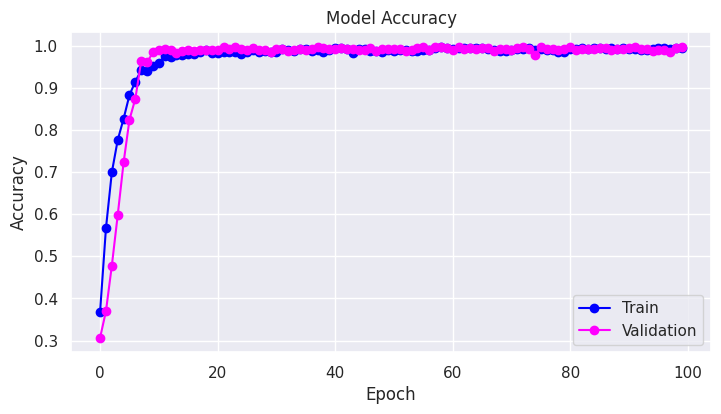

In [ ]:
import seaborn as sns
#  "Accuracy"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(efficientnet_b4.history['accuracy'], 'o-',color="blue")
plt.plot(efficientnet_b4.history['val_accuracy'] ,'o-', color="magenta")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
#plt.close()

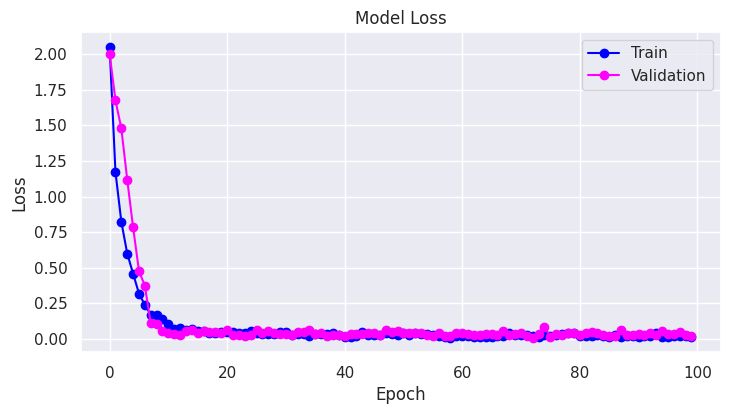

In [ ]:
# "Loss"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(efficientnet_b4.history['loss'],'o-', color="blue")
plt.plot(efficientnet_b4.history['val_loss'],'o-', color="magenta")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])

In [ ]:
valid_loss, valid_acc = e_model_b4.evaluate(X_valid, Y_valid)
train_loss, train_acc=e_model_b4.evaluate(X_train, Y_train)
print('\nValidation Accuracy:', valid_acc)
print('\nValidation Loss:', valid_loss)
print('\nTrain Accuracy:', train_acc)
print('\nTrain Loss:', train_loss)

94/94 [==============================] - 6s 60ms/step - loss: 0.0027 - accuracy: 0.9997

Validation Accuracy: 0.996666669845581

Validation Loss: 0.022064153105020523

Train Accuracy: 0.999666690826416

Train Loss: 0.0026623541489243507


In [ ]:
score = e_model_b4.evaluate(X_valid,Y_valid,verbose=0)
print("Accuracy: ",np.round(score[1]*100,3),"%")

Accuracy:  99.667 %


In [ ]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

testX_arg = np.argmax(Y_valid)
y_pred = np.argmax(e_model_b4.predict(X_valid), axis=1)
y_true = np.argmax(Y_valid)
# print(y_pred)
# print(y_pred.shape)
cm = confusion_matrix(Y_valid,y_pred)
print(classification_report(Y_valid, y_pred,  digits=3,target_names = dataset_classes))

19/19 [==============================] - 3s 55ms/step
                                  precision    recall  f1-score   support

    Other_diseases_abnormalities      0.987     0.987     0.987        75
             Pathological_Myopia      1.000     1.000     1.000        75
                    Hypertension      1.000     1.000     1.000        75
                          Normal      1.000     1.000     1.000        75
                        Cataract      1.000     1.000     1.000        75
                        Diabetes      0.987     0.987     0.987        75
                        Glaucoma      1.000     1.000     1.000        75
Age_related_Macular_Degeneration      1.000     1.000     1.000        75

                        accuracy                          0.997       600
                       macro avg      0.997     0.997     0.997       600
                    weighted avg      0.997     0.997     0.997       600



### Evaluate Validation Dataset

<Axes: title={'center': 'Confusion Matrix'}>

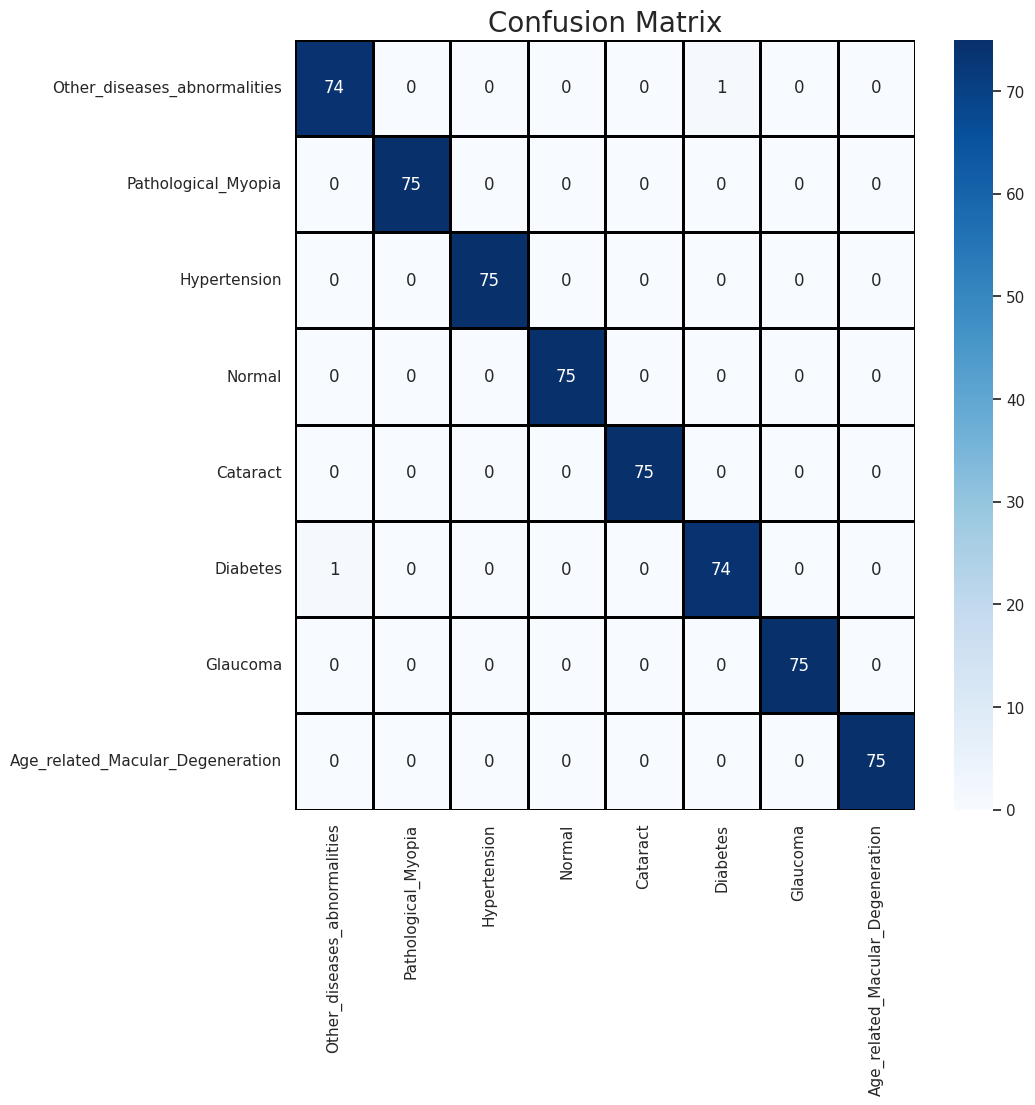

In [ ]:
import pandas as pd
cm = pd.DataFrame(cm , index = dataset_classes , columns = dataset_classes)
plt.figure(figsize = (10,10))
plt.title("Confusion Matrix", fontsize =20)
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = dataset_classes,yticklabels = dataset_classes)

19/19 [==============================] - 1s 55ms/step


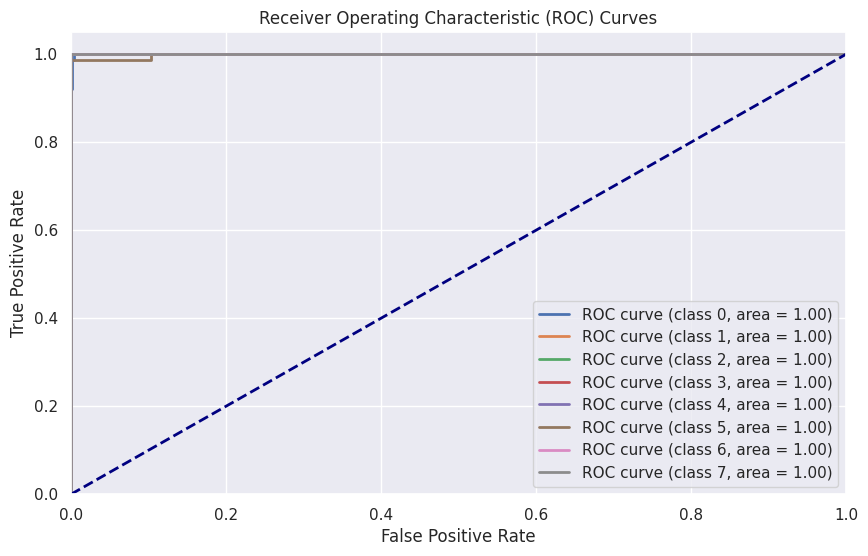

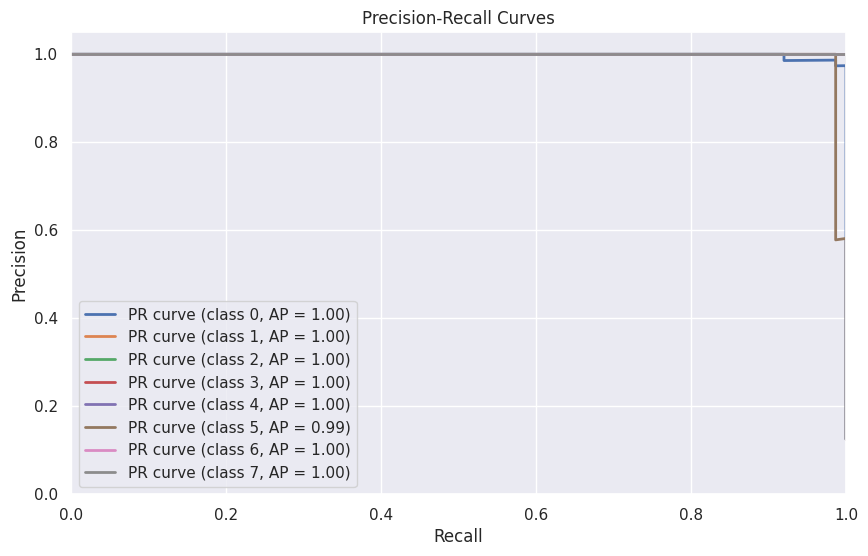

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
model_output = e_model_b4.predict(X_valid)
n_classes = len(dataset_classes)
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_valid == i, model_output[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    precision[i], recall[i], _ = precision_recall_curve(Y_valid == i, model_output[:, i])
    average_precision[i] = auc(recall[i], precision[i])

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (class {i}, area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="best")
plt.show()

# Plot PR curves
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'PR curve (class {i}, AP = {average_precision[i]:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="best")
plt.show()

## Evaluate Test Dataset

In [ ]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

testX_arg = np.argmax(Y_test)
y_pred = np.argmax(e_model_b4.predict(X_test), axis=1)
y_true = np.argmax(Y_test)
# print(y_pred)
# print(y_pred.shape)
cm = confusion_matrix(Y_test,y_pred)
print(classification_report(Y_test, y_pred,  digits=3,target_names = dataset_classes))

13/13 [==============================] - 1s 109ms/step
                                  precision    recall  f1-score   support

    Other_diseases_abnormalities      0.933     0.840     0.884        50
             Pathological_Myopia      1.000     1.000     1.000        50
                    Hypertension      0.960     0.960     0.960        50
                          Normal      0.955     0.840     0.894        50
                        Cataract      0.980     1.000     0.990        50
                        Diabetes      0.825     0.940     0.879        50
                        Glaucoma      0.980     1.000     0.990        50
Age_related_Macular_Degeneration      0.942     0.980     0.961        50

                        accuracy                          0.945       400
                       macro avg      0.947     0.945     0.945       400
                    weighted avg      0.947     0.945     0.945       400



<Axes: title={'center': 'Confusion Matrix'}>

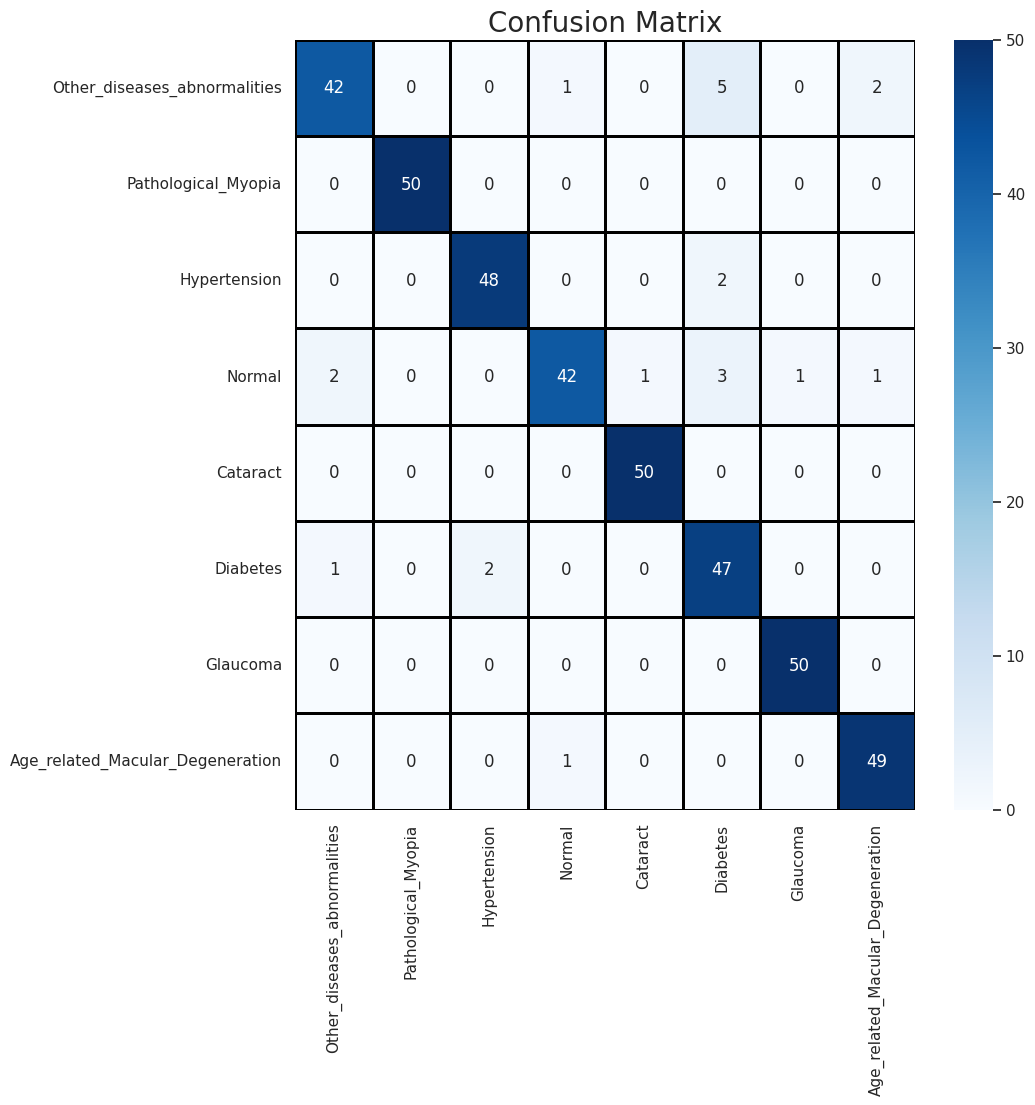

In [ ]:
import pandas as pd
cm = pd.DataFrame(cm , index = dataset_classes , columns = dataset_classes)
plt.figure(figsize = (10,10))
plt.title("Confusion Matrix", fontsize =20)
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = dataset_classes,yticklabels = dataset_classes)

### Efficient B0

In [ ]:
!pip install -q efficientnet
import efficientnet.tfkeras as efn

enet = efn.EfficientNetB0(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet',
    include_top=False
)
x = enet.output
x = tf.keras.layers.GlobalMaxPooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
y = tf.keras.layers.Dense(number_of_classes, activation='softmax')(x)

e_model_b0 = tf.keras.Model(inputs=enet.input, outputs=y)
e_model_b0.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.6 MB/s eta 0:00:00
16804768/16804768 [==============================] - 0s 0us/step


In [ ]:
efficientnet_b0 = e_model_b0.fit(x=X_train, y=Y_train, epochs=100, validation_data=(X_valid, Y_valid), batch_size=64)

Epoch 1/100
47/47 [==============================] - 85s 283ms/step - loss: 1.8918 - accuracy: 0.4087 - val_loss: 2.6965 - val_accuracy: 0.1900
Epoch 2/100
47/47 [==============================] - 9s 191ms/step - loss: 1.0263 - accuracy: 0.6387 - val_loss: 2.3749 - val_accuracy: 0.2367
Epoch 3/100
47/47 [==============================] - 9s 191ms/step - loss: 0.6347 - accuracy: 0.7573 - val_loss: 2.3655 - val_accuracy: 0.2633
Epoch 4/100
47/47 [==============================] - 11s 230ms/step - loss: 0.4430 - accuracy: 0.8337 - val_loss: 2.3840 - val_accuracy: 0.3233
Epoch 5/100
47/47 [==============================] - 9s 181ms/step - loss: 0.2833 - accuracy: 0.9010 - val_loss: 1.8762 - val_accuracy: 0.4467
Epoch 6/100
47/47 [==============================] - 8s 176ms/step - loss: 0.2074 - accuracy: 0.9297 - val_loss: 1.2351 - val_accuracy: 0.6217
Epoch 7/100
47/47 [==============================] - 8s 171ms/step - loss: 0.1559 - accuracy: 0.9493 - val_loss: 1.0015 - val_accuracy: 0.70

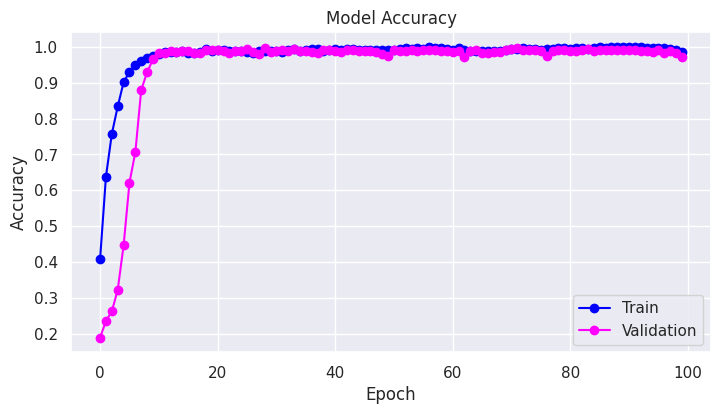

In [ ]:
import seaborn as sns
#  "Accuracy"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(efficientnet_b0.history['accuracy'], 'o-',color="blue")
plt.plot(efficientnet_b0.history['val_accuracy'] ,'o-', color="magenta")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
#plt.close()

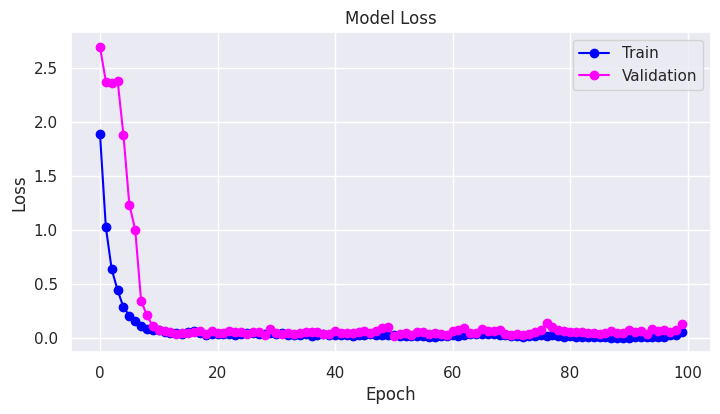

In [ ]:
# "Loss"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(efficientnet_b0.history['loss'],'o-', color="blue")
plt.plot(efficientnet_b0.history['val_loss'],'o-', color="magenta")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])

In [ ]:
valid_loss, valid_acc = e_model_b0.evaluate(X_valid, Y_valid)
train_loss, train_acc=e_model_b0.evaluate(X_train, Y_train)
print('\nValidation Accuracy:', valid_acc)
print('\nValidation Loss:', valid_loss)
print('\nTrain Accuracy:', train_acc)
print('\nTrain Loss:', train_loss)


94/94 [==============================] - 2s 26ms/step - loss: 0.0421 - accuracy: 0.9867

Validation Accuracy: 0.971666693687439

Validation Loss: 0.1253788024187088

Train Accuracy: 0.9866666793823242

Train Loss: 0.042113009840250015


In [ ]:
score = e_model_b0.evaluate(X_valid,Y_valid,verbose=0)
print("Accuracy: ",np.round(score[1]*100,3),"%")

Accuracy:  97.167 %


In [ ]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

testX_arg = np.argmax(Y_valid)
y_pred = np.argmax(e_model_b0.predict(X_valid), axis=1)
y_true = np.argmax(Y_valid)
# print(y_pred)
# print(y_pred.shape)
cm = confusion_matrix(Y_valid,y_pred)
print(classification_report(Y_valid, y_pred,  digits=3,target_names = dataset_classes))

19/19 [==============================] - 2s 24ms/step
                                  precision    recall  f1-score   support

Age_related_Macular_Degeneration      0.987     1.000     0.993        75
                        Cataract      1.000     1.000     1.000        75
                        Diabetes      0.887     0.947     0.916        75
                        Glaucoma      0.987     1.000     0.993        75
                    Hypertension      0.949     1.000     0.974        75
                          Normal      0.971     0.880     0.923        75
    Other_diseases_abnormalities      1.000     0.947     0.973        75
             Pathological_Myopia      1.000     1.000     1.000        75

                        accuracy                          0.972       600
                       macro avg      0.973     0.972     0.972       600
                    weighted avg      0.973     0.972     0.972       600



### Evaluate Validation Dataset

<Axes: title={'center': 'Confusion Matrix'}>

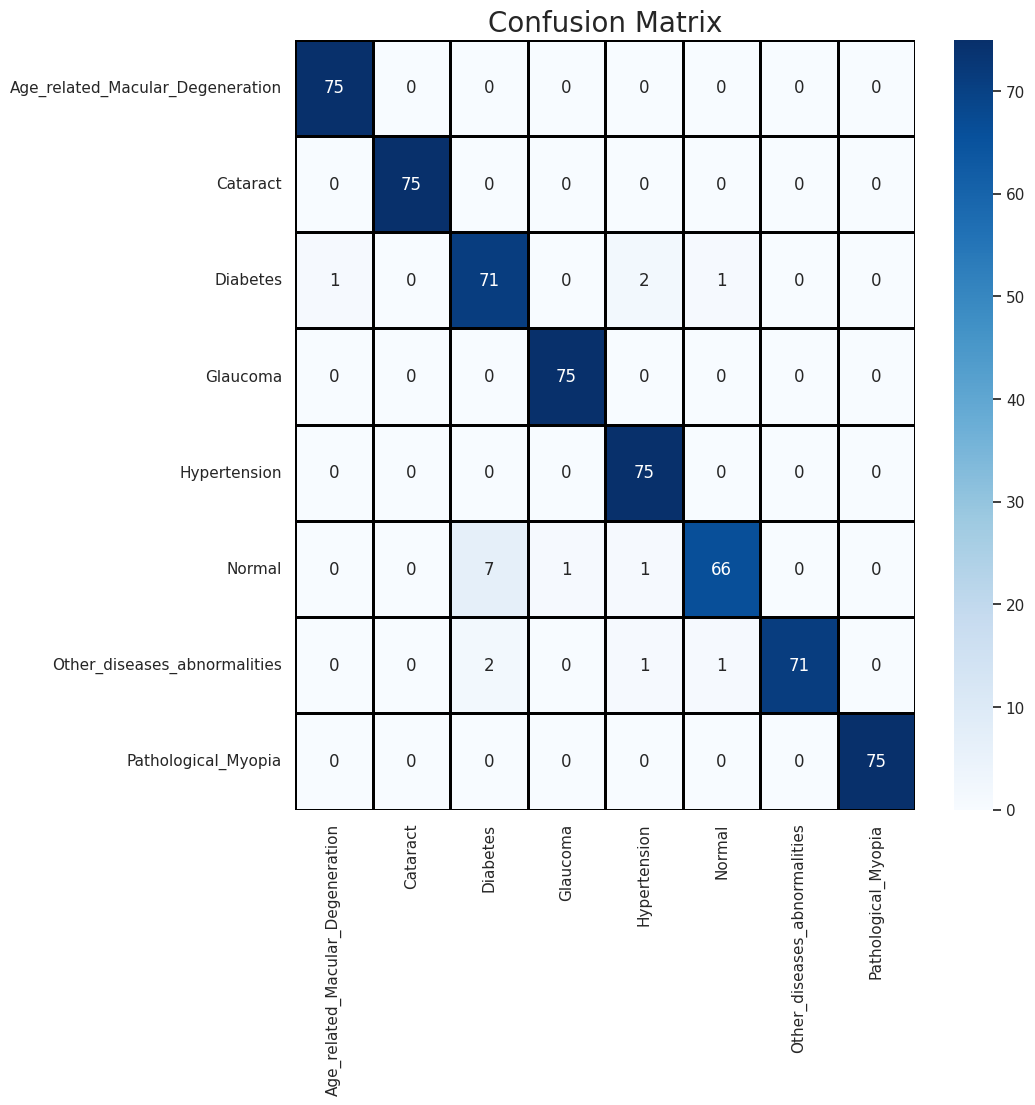

In [ ]:
import pandas as pd
cm = pd.DataFrame(cm , index = dataset_classes , columns = dataset_classes)
plt.figure(figsize = (10,10))
plt.title("Confusion Matrix", fontsize =20)
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = dataset_classes,yticklabels = dataset_classes)

19/19 [==============================] - 0s 20ms/step


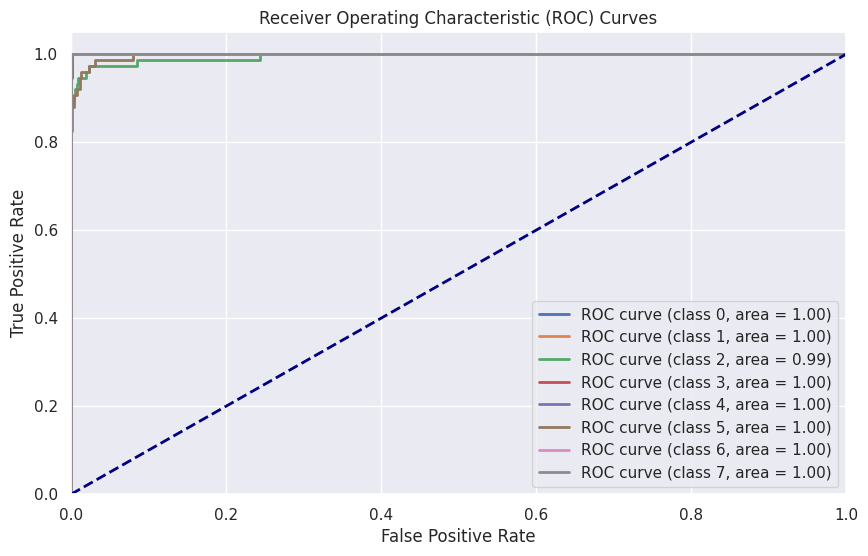

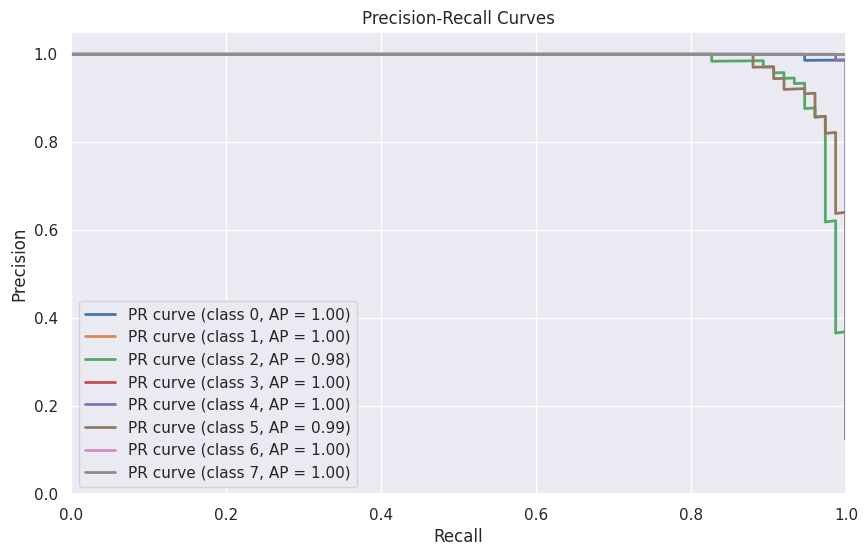

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
model_output = e_model_b0.predict(X_valid)
n_classes = len(dataset_classes)
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_valid == i, model_output[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    precision[i], recall[i], _ = precision_recall_curve(Y_valid == i, model_output[:, i])
    average_precision[i] = auc(recall[i], precision[i])

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (class {i}, area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="best")
plt.show()

# Plot PR curves
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'PR curve (class {i}, AP = {average_precision[i]:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="best")
plt.show()

## Evaluate Test Dataset

In [ ]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

testX_arg = np.argmax(Y_test)
y_pred = np.argmax(e_model_b0.predict(X_test), axis=1)
y_true = np.argmax(Y_test)
# print(y_pred)
# print(y_pred.shape)
cm = confusion_matrix(Y_test,y_pred)
print(classification_report(Y_test, y_pred,  digits=3,target_names = dataset_classes))

13/13 [==============================] - 1s 57ms/step
                                  precision    recall  f1-score   support

Age_related_Macular_Degeneration      0.891     0.980     0.933        50
                        Cataract      1.000     1.000     1.000        50
                        Diabetes      0.772     0.880     0.822        50
                        Glaucoma      0.893     1.000     0.943        50
                    Hypertension      0.860     0.980     0.916        50
                          Normal      0.846     0.660     0.742        50
    Other_diseases_abnormalities      0.972     0.700     0.814        50
             Pathological_Myopia      1.000     1.000     1.000        50

                        accuracy                          0.900       400
                       macro avg      0.904     0.900     0.896       400
                    weighted avg      0.904     0.900     0.896       400



<Axes: title={'center': 'Confusion Matrix'}>

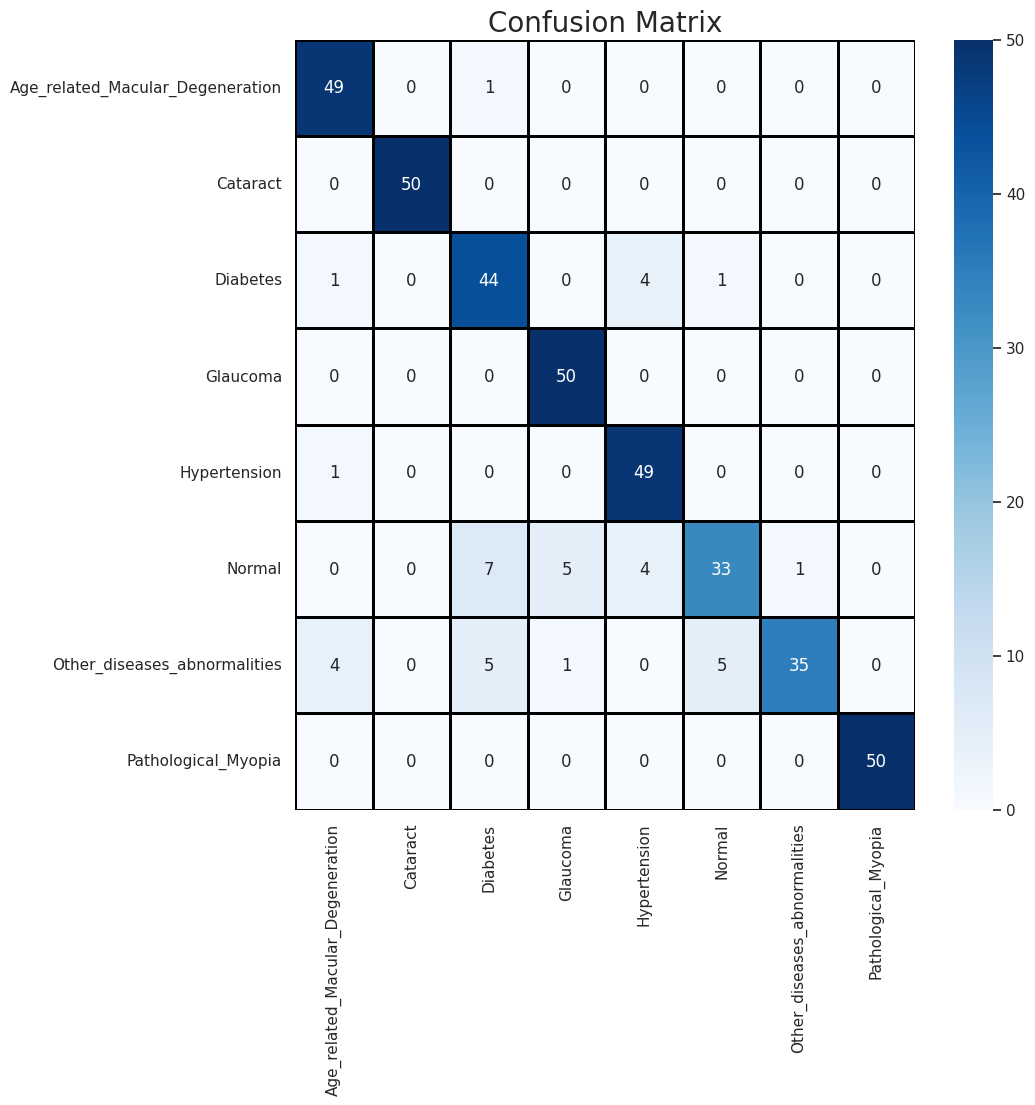

In [ ]:
import pandas as pd
cm = pd.DataFrame(cm , index = dataset_classes , columns = dataset_classes)
plt.figure(figsize = (10,10))
plt.title("Confusion Matrix", fontsize =20)
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = dataset_classes,yticklabels = dataset_classes)

InceptionV3

In [ ]:

import tensorflow as tf

# Load InceptionV3 model without the top (classification) layers
inception = tf.keras.applications.InceptionV3(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet'  # Use 'None' to load without pre-trained weights
)

# Freeze the base InceptionV3 layers
inception.trainable = False

# Create your custom classification head
x = tf.keras.layers.GlobalAveragePooling2D()(inception.output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.BatchNormalization()(x)
y = tf.keras.layers.Dense(8, activation='softmax')(x)

# Combine the base InceptionV3 model with the custom head
inception_model = tf.keras.Model(inputs=inception.input, outputs=y)

# Compile the model
inception_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate= 0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
# Learning Rate Schedule
def lr_schedule(epoch):
    return learning_rate * 0.95**epoch

lr_scheduler = LearningRateScheduler(lr_schedule)



In [ ]:
inceptionv3  = inception_model.fit(X_train, Y_train, epochs=100, validation_data=(X_valid, Y_valid), batch_size=64, callbacks=[lr_scheduler])


Epoch 1/100
47/47 [==============================] - 9s 108ms/step - loss: 1.7018 - accuracy: 0.3857 - val_loss: 1.2748 - val_accuracy: 0.5283 - lr: 1.0000e-04
Epoch 2/100
47/47 [==============================] - 3s 59ms/step - loss: 1.2385 - accuracy: 0.5303 - val_loss: 1.1344 - val_accuracy: 0.5683 - lr: 9.5000e-05
Epoch 3/100
47/47 [==============================] - 3s 53ms/step - loss: 1.0845 - accuracy: 0.6057 - val_loss: 1.0353 - val_accuracy: 0.6100 - lr: 9.0250e-05
Epoch 4/100
47/47 [==============================] - 3s 57ms/step - loss: 0.9775 - accuracy: 0.6483 - val_loss: 0.9392 - val_accuracy: 0.6750 - lr: 8.5737e-05
Epoch 5/100
47/47 [==============================] - 2s 52ms/step - loss: 0.9055 - accuracy: 0.6813 - val_loss: 0.8477 - val_accuracy: 0.7183 - lr: 8.1451e-05
Epoch 6/100
47/47 [==============================] - 3s 57ms/step - loss: 0.8355 - accuracy: 0.7120 - val_loss: 0.7757 - val_accuracy: 0.7583 - lr: 7.7378e-05
Epoch 7/100
47/47 [==========================

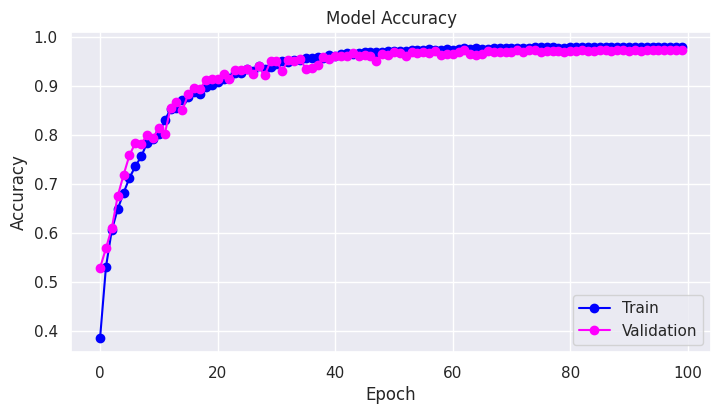

In [ ]:
#  "Accuracy"
import seaborn as sns
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(inceptionv3.history['accuracy'], 'o-',color="blue")
plt.plot(inceptionv3.history['val_accuracy'] ,'o-', color="magenta")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
#plt.close()

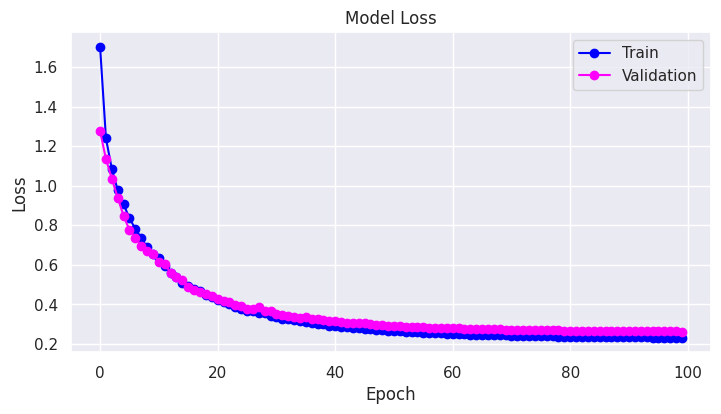

In [ ]:

# "Loss"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(inceptionv3.history['loss'],'o-', color="blue")
plt.plot(inceptionv3.history['val_loss'],'o-', color="magenta")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])

In [ ]:
valid_loss, valid_acc = inception_model.evaluate(X_valid, Y_valid)
train_loss, train_acc=inception_model.evaluate(X_train, Y_train)
print('\nValidation Accuracy:', valid_acc)
print('\nValidation Loss:', valid_loss)
print('\nTrain Accuracy:', train_acc)
print('\nTrain Loss:', train_loss)

94/94 [==============================] - 3s 29ms/step - loss: 0.2314 - accuracy: 0.9793

Validation Accuracy: 0.9733333587646484

Validation Loss: 0.2632579505443573

Train Accuracy: 0.9793333411216736

Train Loss: 0.2313513606786728


In [ ]:
score = inception_model.evaluate(X_valid,Y_valid,verbose=0)
print("Accuracy: ",np.round(score[1]*100,3),"%")

Accuracy:  97.333 %


In [ ]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

testX_arg = np.argmax(Y_valid)
y_pred = np.argmax(inception_model.predict(X_valid), axis=1)
y_true = np.argmax(Y_valid)
# print(y_pred)
# print(y_pred.shape)
cm = confusion_matrix(Y_valid,y_pred)
print(classification_report(Y_valid, y_pred,  digits=3,target_names = dataset_classes))

19/19 [==============================] - 1s 30ms/step
                                  precision    recall  f1-score   support

Age_related_Macular_Degeneration      0.961     0.987     0.974        75
                        Cataract      1.000     1.000     1.000        75
                        Diabetes      0.943     0.880     0.910        75
                        Glaucoma      0.987     0.987     0.987        75
                    Hypertension      0.987     1.000     0.993        75
                          Normal      1.000     0.947     0.973        75
    Other_diseases_abnormalities      0.914     0.987     0.949        75
             Pathological_Myopia      1.000     1.000     1.000        75

                        accuracy                          0.973       600
                       macro avg      0.974     0.973     0.973       600
                    weighted avg      0.974     0.973     0.973       600



Evaluate Validation

<Axes: title={'center': 'Confusion Matrix'}>

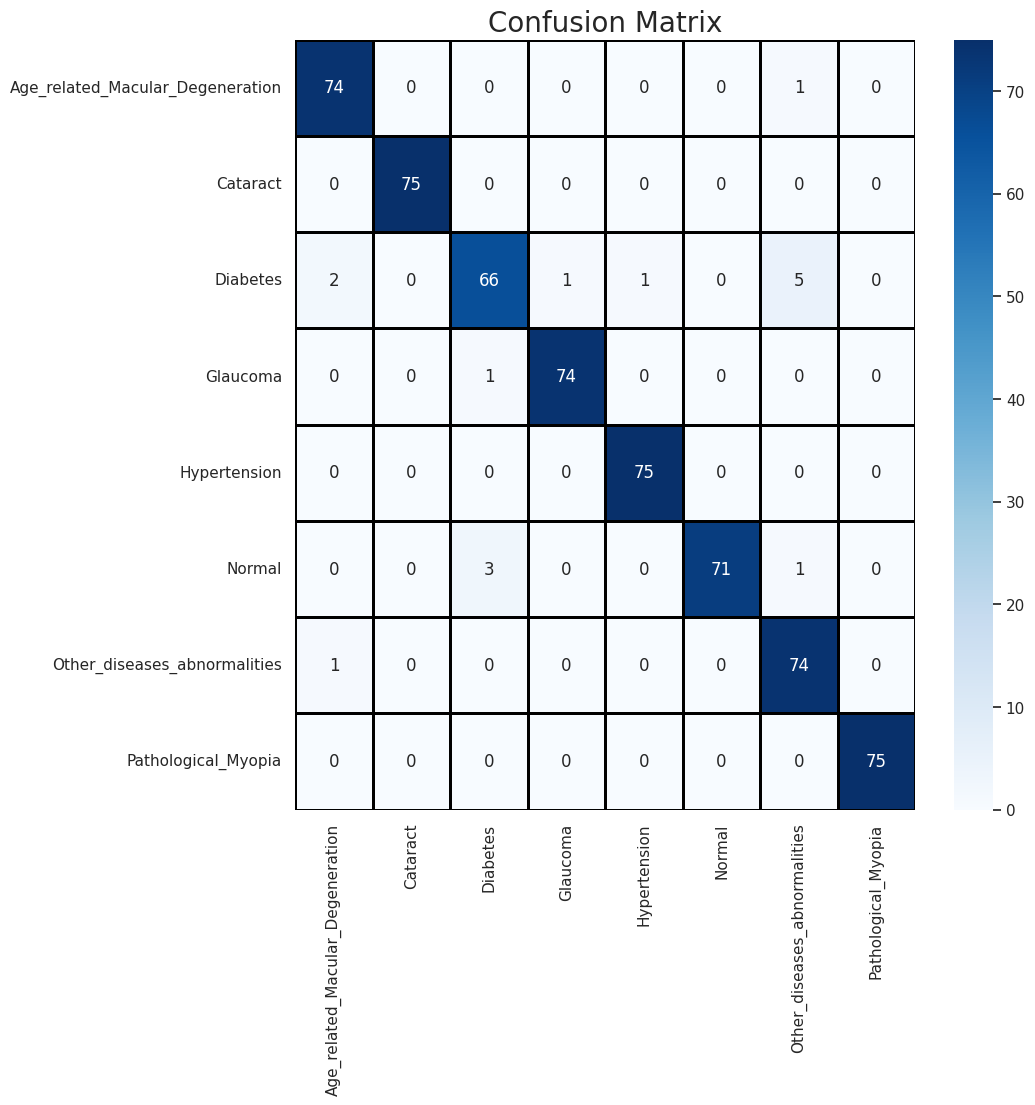

In [ ]:
import pandas as pd
cm = pd.DataFrame(cm , index = dataset_classes , columns = dataset_classes)
plt.figure(figsize = (10,10))
plt.title("Confusion Matrix", fontsize =20)
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = dataset_classes,yticklabels = dataset_classes)

19/19 [==============================] - 1s 30ms/step


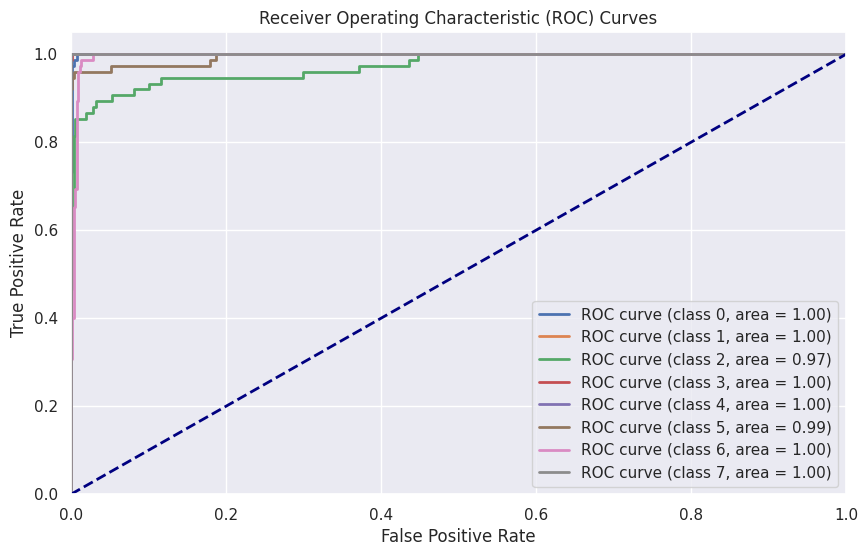

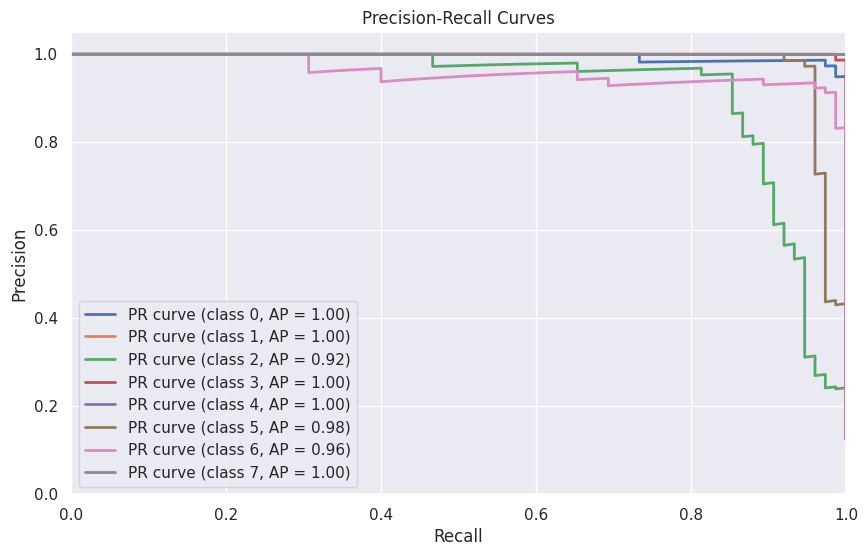

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
model_output = inception_model.predict(X_valid)
n_classes = len(dataset_classes)
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_valid == i, model_output[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    precision[i], recall[i], _ = precision_recall_curve(Y_valid == i, model_output[:, i])
    average_precision[i] = auc(recall[i], precision[i])

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (class {i}, area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="best")
plt.show()

# Plot PR curves
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'PR curve (class {i}, AP = {average_precision[i]:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="best")
plt.show()

Evaluate Test Dataset

In [ ]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

testX_arg = np.argmax(Y_test)
y_pred = np.argmax(inception_model.predict(X_test), axis=1)
y_true = np.argmax(Y_test)
# print(y_pred)
# print(y_pred.shape)
cm = confusion_matrix(Y_test,y_pred)
print(classification_report(Y_test, y_pred,  digits=3,target_names = dataset_classes))

13/13 [==============================] - 0s 32ms/step
                                  precision    recall  f1-score   support

Age_related_Macular_Degeneration      0.800     0.880     0.838        50
                        Cataract      0.942     0.980     0.961        50
                        Diabetes      0.589     0.660     0.623        50
                        Glaucoma      0.889     0.960     0.923        50
                    Hypertension      0.918     0.900     0.909        50
                          Normal      0.865     0.640     0.736        50
    Other_diseases_abnormalities      0.761     0.700     0.729        50
             Pathological_Myopia      0.980     1.000     0.990        50

                        accuracy                          0.840       400
                       macro avg      0.843     0.840     0.839       400
                    weighted avg      0.843     0.840     0.839       400



<Axes: title={'center': 'Confusion Matrix'}>

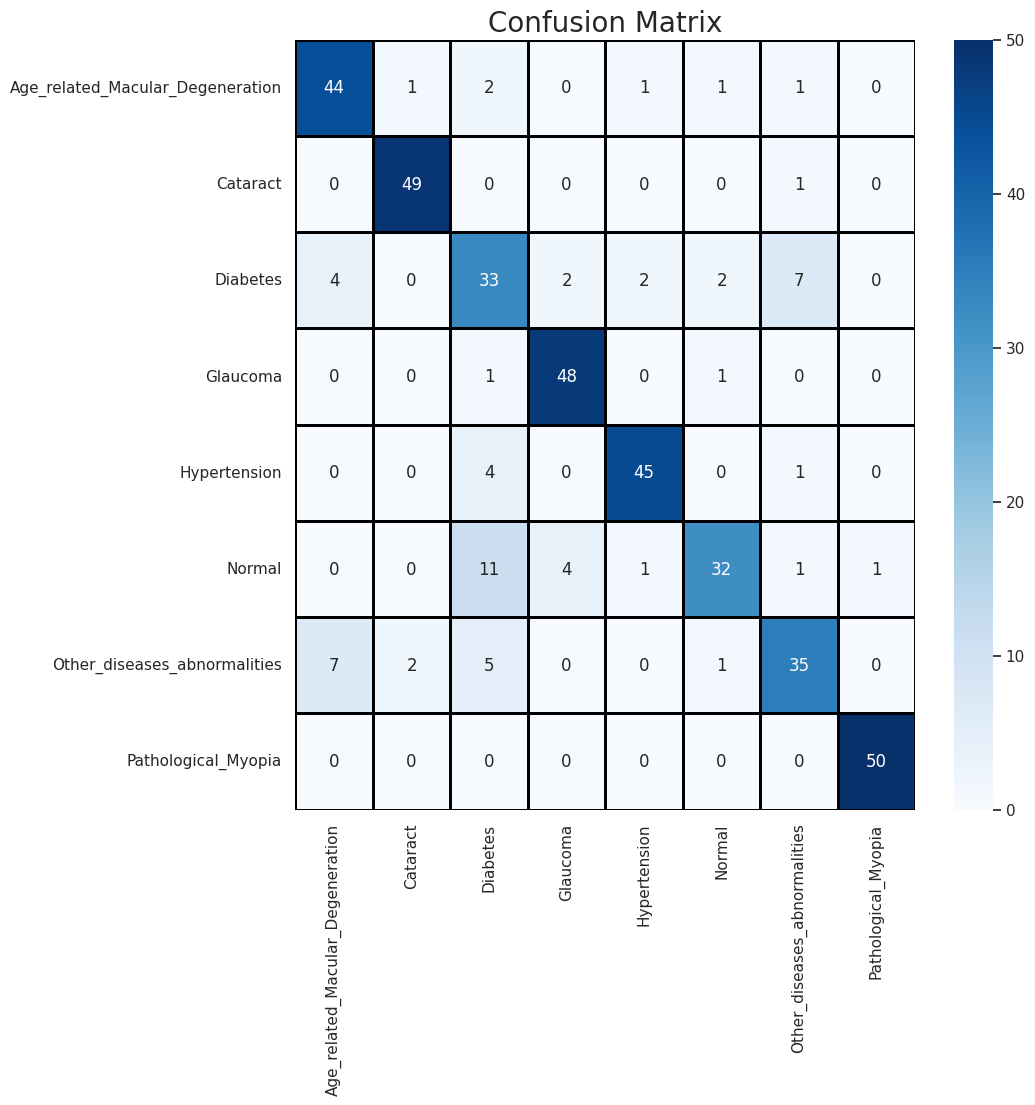

In [ ]:
import pandas as pd
cm = pd.DataFrame(cm , index = dataset_classes , columns = dataset_classes)
plt.figure(figsize = (10,10))
plt.title("Confusion Matrix", fontsize =20)
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = dataset_classes,yticklabels = dataset_classes)

### Densenet201

In [28]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Load the DenseNet121 model with pre-trained weights (include_top=False for feature extraction)
DenseNet201_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze all layers of the pre-trained model
for layer in DenseNet201_model.layers:
    layer.trainable = False

# Create a new Sequential model
DenseNet201_custom_model = Sequential()
DenseNet201_custom_model.add(DenseNet201_model)
DenseNet201_custom_model.add(Flatten())
DenseNet201_custom_model.add(Dense(128, activation='relu'))
DenseNet201_custom_model.add(Dense(number_of_classes, activation='softmax'))
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
DenseNet201_custom_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [29]:
DenseNet201_pretrained = DenseNet201_custom_model.fit(X_train, Y_train, epochs=100, validation_data=(X_valid, Y_valid), batch_size=64)

Epoch 1/100
47/47 [==============================] - 32s 322ms/step - loss: 3.7349 - accuracy: 0.4000 - val_loss: 1.0774 - val_accuracy: 0.5583
Epoch 2/100
47/47 [==============================] - 6s 125ms/step - loss: 0.9501 - accuracy: 0.6467 - val_loss: 0.7771 - val_accuracy: 0.7067
Epoch 3/100
47/47 [==============================] - 6s 135ms/step - loss: 0.7431 - accuracy: 0.7333 - val_loss: 0.5912 - val_accuracy: 0.8383
Epoch 4/100
47/47 [==============================] - 6s 132ms/step - loss: 0.6388 - accuracy: 0.7690 - val_loss: 0.5165 - val_accuracy: 0.8517
Epoch 5/100
47/47 [==============================] - 6s 138ms/step - loss: 0.5562 - accuracy: 0.8027 - val_loss: 0.4879 - val_accuracy: 0.8400
Epoch 6/100
47/47 [==============================] - 6s 137ms/step - loss: 0.5000 - accuracy: 0.8313 - val_loss: 0.3675 - val_accuracy: 0.9017
Epoch 7/100
47/47 [==============================] - 6s 133ms/step - loss: 0.4184 - accuracy: 0.8610 - val_loss: 0.3695 - val_accuracy: 0.883

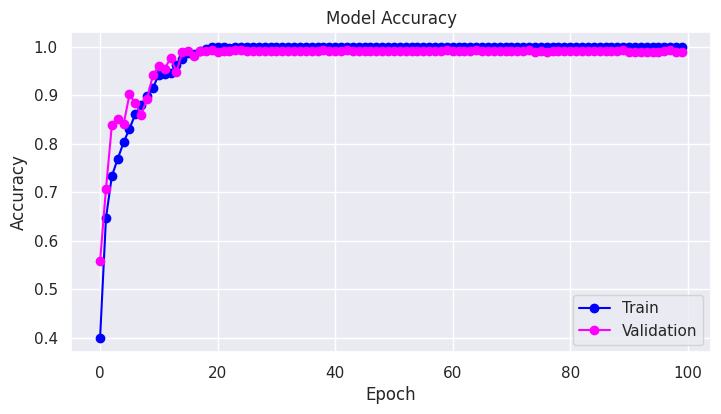

In [30]:
#  "Accuracy"
import seaborn as sns
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(DenseNet201_pretrained.history['accuracy'], 'o-',color="blue")
plt.plot(DenseNet201_pretrained.history['val_accuracy'] ,'o-', color="magenta")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
#plt.close()

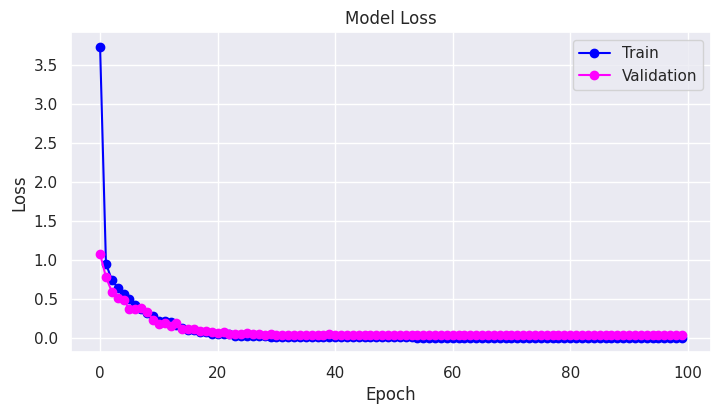

In [31]:
# "Loss"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(DenseNet201_pretrained.history['loss'],'o-', color="blue")
plt.plot(DenseNet201_pretrained.history['val_loss'],'o-', color="magenta")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])

In [32]:
valid_loss, valid_acc = DenseNet201_custom_model.evaluate(X_valid, Y_valid)
train_loss, train_acc=DenseNet201_custom_model.evaluate(X_train, Y_train)
print('\nValidation Accuracy:', valid_acc)
print('\nValidation Loss:', valid_loss)
print('\nTrain Accuracy:', train_acc)
print('\nTrain Loss:', train_loss)

94/94 [==============================] - 6s 61ms/step - loss: 5.3075e-04 - accuracy: 1.0000

Validation Accuracy: 0.9900000095367432

Validation Loss: 0.03955230861902237

Train Accuracy: 1.0

Train Loss: 0.0005307484534569085


In [33]:
score = DenseNet201_custom_model.evaluate(X_valid,Y_valid,verbose=0)
print("Accuracy: ",np.round(score[1]*100,3),"%")

Accuracy:  99.0 %


In [34]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

testX_arg = np.argmax(Y_valid)
y_pred = np.argmax(DenseNet201_custom_model.predict(X_valid), axis=1)
y_true = np.argmax(Y_valid)
# print(y_pred)
# print(y_pred.shape)
cm = confusion_matrix(Y_valid,y_pred)
print(classification_report(Y_valid, y_pred,  digits=3,target_names = dataset_classes))

19/19 [==============================] - 5s 67ms/step
                                  precision    recall  f1-score   support

             Pathological_Myopia      1.000     1.000     1.000        75
    Other_diseases_abnormalities      0.974     1.000     0.987        75
                          Normal      0.986     0.973     0.980        75
                    Hypertension      0.987     1.000     0.993        75
                        Glaucoma      1.000     1.000     1.000        75
                        Diabetes      1.000     0.947     0.973        75
                        Cataract      1.000     1.000     1.000        75
Age_related_Macular_Degeneration      0.974     1.000     0.987        75

                        accuracy                          0.990       600
                       macro avg      0.990     0.990     0.990       600
                    weighted avg      0.990     0.990     0.990       600



### Evaluate Validation Dataset

<Axes: title={'center': 'Confusion Matrix'}>

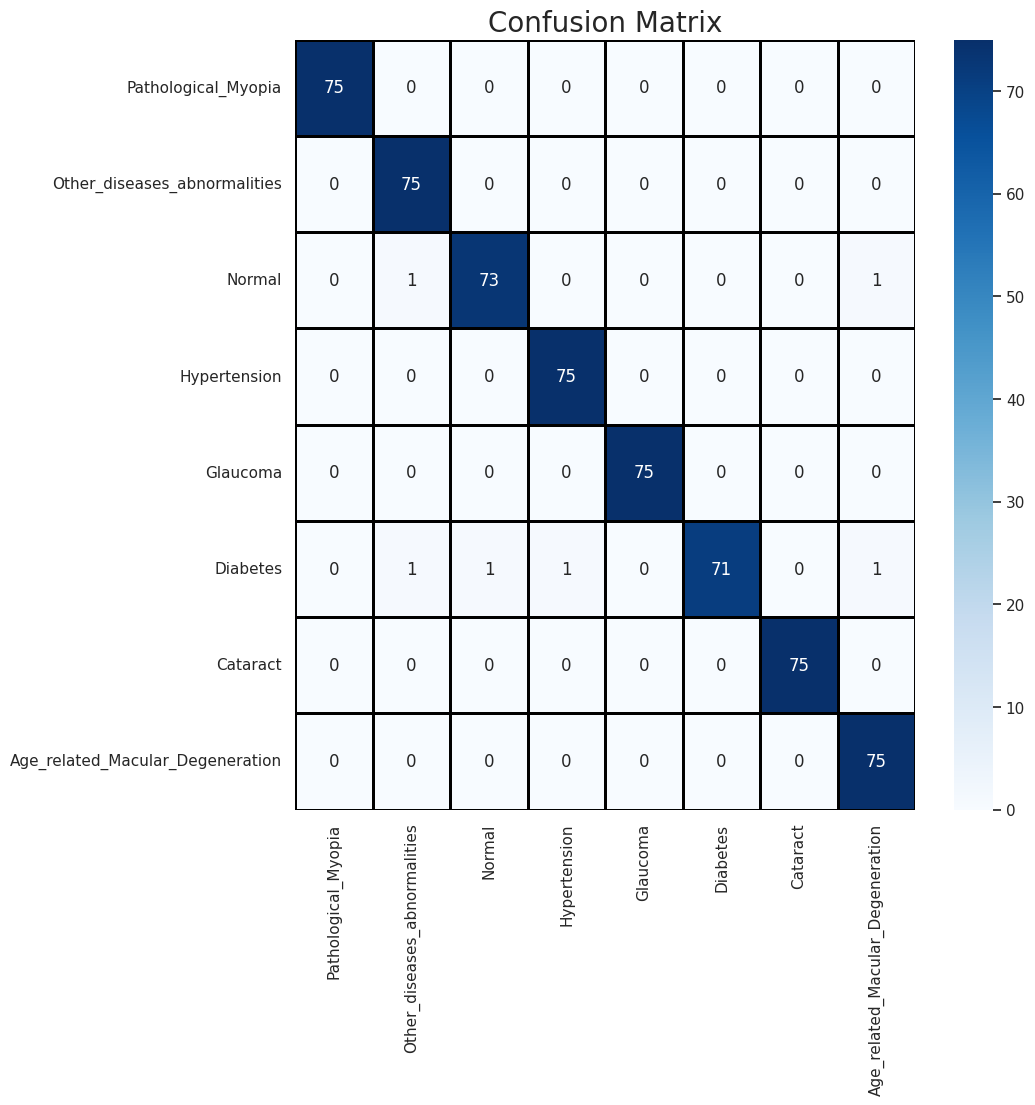

In [35]:
import pandas as pd
cm = pd.DataFrame(cm , index = dataset_classes , columns = dataset_classes)
plt.figure(figsize = (10,10))
plt.title("Confusion Matrix", fontsize =20)
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = dataset_classes,yticklabels = dataset_classes)

19/19 [==============================] - 1s 59ms/step


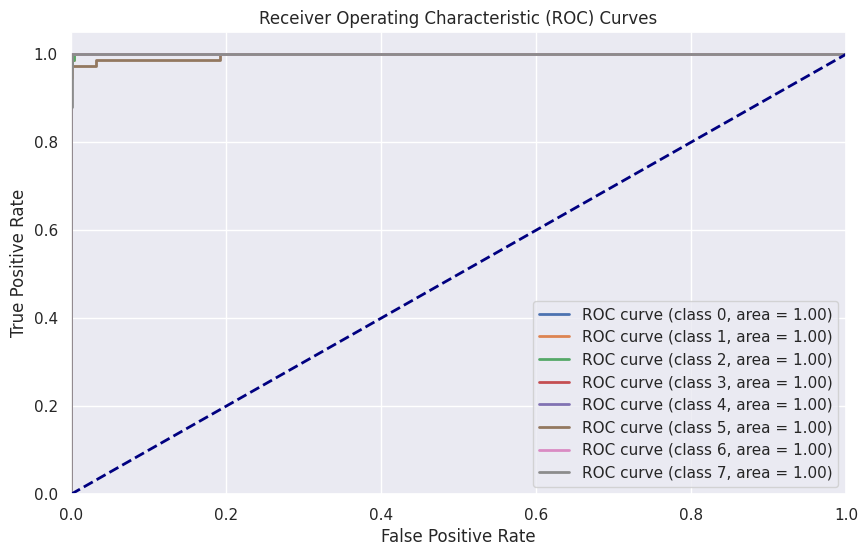

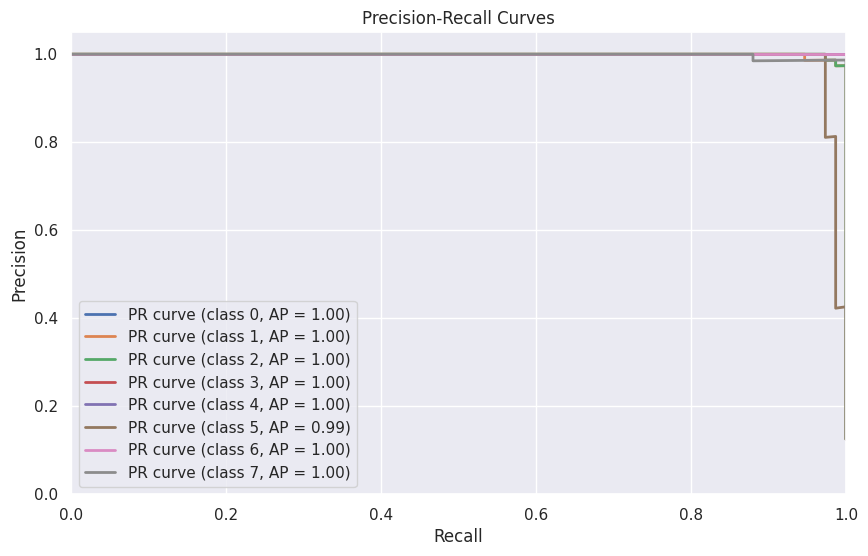

In [36]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
model_output = DenseNet201_custom_model.predict(X_valid)
n_classes = len(dataset_classes)
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_valid == i, model_output[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    precision[i], recall[i], _ = precision_recall_curve(Y_valid == i, model_output[:, i])
    average_precision[i] = auc(recall[i], precision[i])

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (class {i}, area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="best")
plt.show()

# Plot PR curves
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'PR curve (class {i}, AP = {average_precision[i]:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="best")
plt.show()

## Evaluate Test Dataset

In [37]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

testX_arg = np.argmax(Y_test)
y_pred = np.argmax(DenseNet201_custom_model.predict(X_test), axis=1)
y_true = np.argmax(Y_test)
# print(y_pred)
# print(y_pred.shape)
cm = confusion_matrix(Y_test,y_pred)
print(classification_report(Y_test, y_pred,  digits=3,target_names = dataset_classes))

13/13 [==============================] - 3s 218ms/step
                                  precision    recall  f1-score   support

             Pathological_Myopia      1.000     1.000     1.000        50
    Other_diseases_abnormalities      0.804     0.820     0.812        50
                          Normal      0.778     0.700     0.737        50
                    Hypertension      0.925     0.980     0.951        50
                        Glaucoma      1.000     0.980     0.990        50
                        Diabetes      0.796     0.780     0.788        50
                        Cataract      1.000     1.000     1.000        50
Age_related_Macular_Degeneration      0.868     0.920     0.893        50

                        accuracy                          0.897       400
                       macro avg      0.896     0.897     0.896       400
                    weighted avg      0.896     0.897     0.896       400



<Axes: title={'center': 'Confusion Matrix'}>

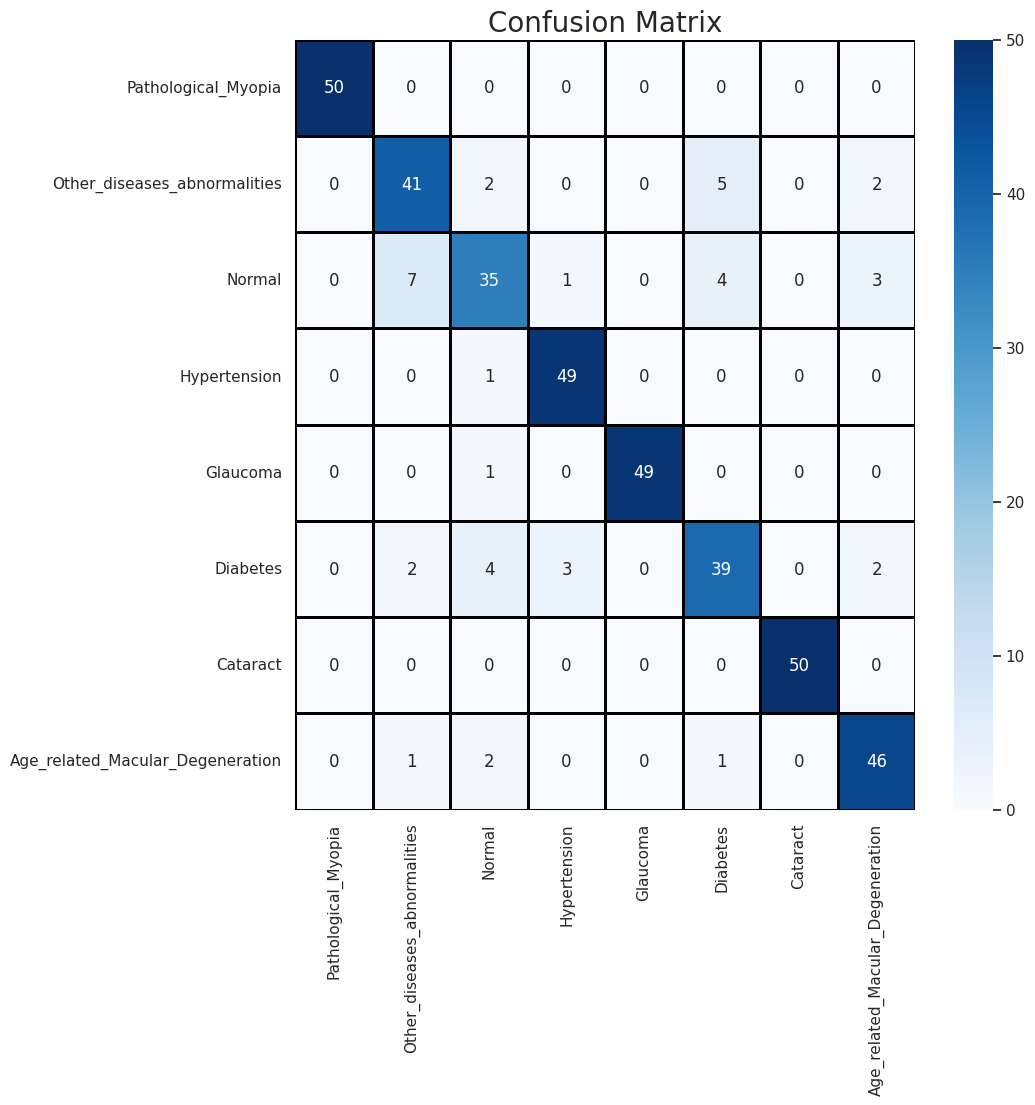

In [38]:
import pandas as pd
cm = pd.DataFrame(cm , index = dataset_classes , columns = dataset_classes)
plt.figure(figsize = (10,10))
plt.title("Confusion Matrix", fontsize =20)
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = dataset_classes,yticklabels = dataset_classes)